In [68]:
try:
    import google.colab # type: ignore
    IN_COLAB = True
except:
    IN_COLAB = False

import os, sys

if IN_COLAB:
    # Code to download the necessary files (e.g. solutions, test funcs)
    if not os.path.exists("chapter1_transformers"):
        !curl -o /content/main.zip https://codeload.github.com/callummcdougall/ARENA_2.0/zip/refs/heads/main
        !unzip /content/main.zip 'ARENA_2.0-main/chapter1_transformers/exercises/*'
        sys.path.append("/content/ARENA_2.0-main/chapter1_transformers/exercises")
        os.remove("/content/main.zip")
        os.rename("ARENA_2.0-main/chapter1_transformers", "chapter1_transformers")
        os.rmdir("ARENA_2.0-main")

         # Install packages
        %pip install einops
        %pip install jaxtyping
        %pip install transformer_lens
        %pip install git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python
        %pip install s3fs
        %pip install omegaconf
        %pip install git+https://github.com/CindyXWu/devinterp-automata.git
        %pip install torch-ema

        !curl -o /content/main.zip https://codeload.github.com/CindyXWu/devinterp-automata/zip/refs/heads/main
        !unzip -o /content/main.zip -d /content/

        sys.path.append("/content/devinterp-automata/")
        os.remove("/content/main.zip")

        os.chdir("chapter1_transformers/exercises")
else:
    from IPython import get_ipython
    ipython = get_ipython()
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

    CHAPTER = r"chapter1_transformers"
    CHAPTER_DIR = r"./" if CHAPTER in os.listdir() else os.getcwd().split(CHAPTER)[0]
    EXERCISES_DIR = CHAPTER_DIR + f"{CHAPTER}/exercises"
    sys.path.append(EXERCISES_DIR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
from dotenv import load_dotenv
import plotly.express as px
from typing import List, Union, Optional, Dict, Tuple
from jaxtyping import Int, Float

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
import numpy as np
import pandas as pd
import einops
import re
import functools
from tqdm import tqdm
from IPython.display import display
import webbrowser
import gdown
from transformer_lens.hook_points import HookPoint
from transformer_lens import utils, HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
from transformer_lens.utils import to_numpy

import circuitsvis as cv
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# For Dashiell's groups code
from copy import deepcopy
from functools import reduce
from itertools import product
import math
import numpy as np
from operator import mul
import torch

torch.set_grad_enabled(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAIN = __name__ == "__main__"

import wandb
from pathlib import Path
import os
import yaml
import s3fs
from omegaconf import OmegaConf

from di_automata.config_setup import *
from di_automata.constructors import (
    construct_model,
    create_dataloader_hf,
)
from di_automata.tasks.data_utils import take_n
import plotly.io as pio

# AWS
load_dotenv()
AWS_KEY, AWS_SECRET = os.getenv("AWS_KEY"), os.getenv("AWS_SECRET")
s3 = s3fs.S3FileSystem(key=AWS_KEY, secret=AWS_SECRET)

In [70]:
class DihedralElement:

    def __init__(self, rot: int, ref: int, n: int):
        self.n = n
        self.rot = rot % n
        self.ref = ref % 2

    def __repr__(self):
        return str((self.rot, self.ref))

    def __hash__(self):
        return hash(str(self))

    @property
    def sigma(self):
        return self.rot, self.ref

    @classmethod
    def full_group(cls, n):
        return [
            DihedralElement(r, p, n) for r, p in product(range(n), [0, 1])
        ]

    @property
    def order(self):
        if self.ref:
            return 2
        elif self.rot == 0:
            return 0
        elif (self.n % self.rot) == 0:
            return self.n // self.rot
        else:
            return math.lcm(self.n, self.rot) // self.rot

    @property
    def inverse(self):
        if self.ref:
            return deepcopy(self)
        else:
            return DihedralElement(self.n - self.rot, self.ref, self.n)

    def __mul__(self, other):
        if (not isinstance(other, DihedralElement)) or (other.n != self.n):
            raise ValueError(
                'Can only multiply a dihedral rotation with another dihedral rotation'
            )
        if self.ref:
            rot = self.rot - other.rot
        else:
            rot = self.rot + other.rot
        return DihedralElement(rot, self.ref + other.ref, self.n)

    def __pow__(self, x: int):
        if x == -1:
            return self.inverse
        elif x == 0:
            return DihedralElement(0, 0, self.n)
        elif x == 1:
            return deepcopy(self)
        else:
            return reduce(mul, [deepcopy(self) for _ in range(x)])

    def index(self) -> int:
        return self.rot * self.ref + self.rot


def generate_subgroup(generators, n):
    group_size = 0
    all_elements = set(generators)
    while group_size < len(all_elements):
        group_size = len(all_elements)
        rotations = [DihedralElement(*p, n) for p in all_elements]
        for r1, r2 in product(rotations, repeat=2):
            r3 = r1 * r2
            all_elements.add(r3.sigma)
    return list(all_elements)


def dihedral_conjugacy_classes(n: int):

    conj_classes = [(0, 0), (0, 1)]
    if n % 2 == 1:
        m = (n - 1) // 2
    else:
        m = (n - 2) // 2
        conj_classes += [((2, 0), (0, 1)), ((2, 1), (1, 1))]
    conj_classes += [(i, 0) for i in range(1, m+1)]
    return conj_classes


class DihedralIrrep:

    def __init__(self, n: int, conjugacy_class):
        self.n = n
        self.conjugacy_class = conjugacy_class
        self.group = DihedralElement.full_group(n)

    def _trivial_irrep(self):
        return {r.sigma: torch.ones((1,)) for r in self.group}

    def _reflection_irrep(self):
        return {r.sigma: (-1**r.ref) * torch.ones((1,)) for r in self.group}

    def _subgroup_irrep(self, sg):
        return {r.sigma: 1 if r.sigma in sg else -1 for r in self.group}

    def _matrix_irrep(self, k):
        mats = {}
        mats[(0, 0)] = torch.eye(2)
        ref = torch.tensor([[1.0, 0.0], [0.0, -1.0]], dtype=torch.float32)
        mats[(0, 1)] = ref
        two_pi_n = 2 * torch.pi / self.n
        for idx in range(1, self.n):
            sin = np.sin(two_pi_n * idx * k)
            cos = np.cos(two_pi_n * idx * k)
            m = torch.tensor([[cos, -1.0 * sin], [sin, cos]], dtype=torch.float32)
            mats[(idx, 0)] = m
            mats[(idx, 1)] = ref @ m
        return mats

    def matrix_representations(self):
        if self.conjugacy_class == (0, 0):
            return self._trivial_irrep()
        elif self.conjugacy_class == (0, 1):
            return self._reflection_irrep()
        elif self.conjugacy_class[1] == 0:
            return self._matrix_irrep(self.conjugacy_class[0])
        elif (
            isinstance(self.conjugacy_class[0], tuple) and
            isinstance(self.conjugacy_class[1], tuple)
        ):
            subgroup = generate_subgroup(self.conjugacy_class, self.n)
            return self._subgroup_irrep(subgroup)
        else:
            raise ValueError(
                f'Somehow {self.conjugacy_class} is not a proper conjugacy class....'
            )


class ProductDihedralIrrep:

    def __init__(self, n: int, m: int, conjugacy_classes):

        assert len(conjugacy_classes) == m

        self.m = m
        self.n = n
        self.conjugacy_class = conjugacy_classes
        self.group = [element for element in product(DihedralElement.full_group(n), repeat=m)]
        self.irreps = [
            DihedralIrrep(n, conj_class).matrix_representations() for conj_class in conjugacy_classes
        ]

    def matrix_representations(self):

        reps = {}

        for elements in self.group:
            key = tuple(el.sigma for el in elements)
            matrices = [self.irreps[i][el] for i, el in enumerate(key)]
            reps[key] = reduce(torch.kron, matrices)
        return reps

In [71]:
group = DihedralElement.full_group(5)

In [72]:
translation = {
    (0,0):0,
    (1,0):1,
    (2,0):2,
    (3,0):3,
    (4,0):4,
    (0,1):5,
    (1,1):6,
    (2,1):7,
    (3,1):8,
    (4,1):9,
}

In [73]:
def imshow_attention(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)


In [74]:
update_layout_set = {"xaxis_range", "yaxis_range", "hovermode", "xaxis_title", "yaxis_title", "colorbar", "colorscale", "coloraxis", "title_x", "bargap", "bargroupgap", "xaxis_tickformat", "yaxis_tickformat", "title_y", "legend_title_text", "xaxis_showgrid", "xaxis_gridwidth", "xaxis_gridcolor", "yaxis_showgrid", "yaxis_gridwidth", "yaxis_gridcolor", "showlegend", "xaxis_tickmode", "yaxis_tickmode", "margin", "xaxis_visible", "yaxis_visible", "bargap", "bargroupgap", "coloraxis_showscale", "xaxis_tickangle"}
import torch as t

def imshow(tensor: t.Tensor, renderer=None, **kwargs):
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    facet_labels = kwargs_pre.pop("facet_labels", None)
    border = kwargs_pre.pop("border", False)
    return_fig = kwargs_pre.pop("return_fig", False)
    text = kwargs_pre.pop("text", None)
    xaxis_tickangle = kwargs_post.pop("xaxis_tickangle", None)
    static = kwargs_pre.pop("static", False)
    if "color_continuous_scale" not in kwargs_pre:
        kwargs_pre["color_continuous_scale"] = "RdBu"
    if "color_continuous_midpoint" not in kwargs_pre:
        kwargs_pre["color_continuous_midpoint"] = 0.0
    if "margin" in kwargs_post and isinstance(kwargs_post["margin"], int):
        kwargs_post["margin"] = dict.fromkeys(list("tblr"), kwargs_post["margin"])
    fig = px.imshow(to_numpy(tensor), **kwargs_pre).update_layout(**kwargs_post)
    if facet_labels:
        # Weird thing where facet col wrap means labels are in wrong order
        if "facet_col_wrap" in kwargs_pre:
            facet_labels = reorder_list_in_plotly_way(facet_labels, kwargs_pre["facet_col_wrap"])
        for i, label in enumerate(facet_labels):
            fig.layout.annotations[i]['text'] = label
    if border:
        fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
        fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
    if text:
        if tensor.ndim == 2:
            # if 2D, then we assume text is a list of lists of strings
            assert isinstance(text[0], list)
            assert isinstance(text[0][0], str)
            text = [text]
        else:
            # if 3D, then text is either repeated for each facet, or different
            assert isinstance(text[0], list)
            if isinstance(text[0][0], str):
                text = [text for _ in range(len(fig.data))]
        for i, _text in enumerate(text):
            fig.data[i].update(
                text=_text,
                texttemplate="%{text}",
                textfont={"size": 12}
            )
    # Very hacky way of fixing the fact that updating layout with new tickangle only applies to first facet by default
    if xaxis_tickangle is not None:
        n_facets = 1 if tensor.ndim == 2 else tensor.shape[0]
        for i in range(1, 1+n_facets):
            xaxis_name = "xaxis" if i == 1 else f"xaxis{i}"
            fig.layout[xaxis_name]["tickangle"] = xaxis_tickangle
    return fig if return_fig else fig.show(renderer=renderer, config={"staticPlot": static})

def reorder_list_in_plotly_way(L: list, col_wrap: int):
    '''
    Helper function, because Plotly orders figures in an annoying way when there's column wrap.
    '''
    L_new = []
    while len(L) > 0:
        L_new.extend(L[-col_wrap:])
        L = L[:-col_wrap]
    print(f"Reordered labels: {L_new}")
    return L_new

In [75]:
DI_ROOT = Path("/content/devinterp-automata-main/") if IN_COLAB else Path("../")
config_file_path = DI_ROOT / f"scripts/configs/slt_config.yaml"
slt_config = OmegaConf.load(config_file_path)

with open(DI_ROOT / f"scripts/configs/task_config/{slt_config.dataset_type}.yaml", 'r') as file:
    task_config = yaml.safe_load(file)

In [76]:
OmegaConf.set_struct(slt_config, False) # Allow new configuration values to be added
# Because we are in Colab and not VSCode, here is where you want to edit your config values
slt_config["task_config"] = task_config
slt_config["lr"] = 0.0005
slt_config["num_training_iter"] = 100000
slt_config["n_layers"] = 3

# Convert OmegaConf object to MainConfig Pydantic model for dynamic type validation - NECESSARY DO NOT SKIP
pydantic_config = PostRunSLTConfig(**slt_config)
# Convert back to OmegaConf object for compatibility with existing code
slt_config = OmegaConf.create(pydantic_config.model_dump())

print(task_config["dataset_type"])

dihedral


In [77]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Run path and name for easy referral later
run_path = f"{slt_config.entity_name}/{slt_config.wandb_project_name}"
run_name = slt_config.run_name
print(run_name)

dihedral_TF_LENS_LR0.0005_its100000_layers3_seqlen25_nstates5_prob1None_nactionsNone


In [78]:
# Get run information
api = wandb.Api(timeout=3000)
run_list = api.runs(
    path=run_path,
    filters={
        "display_name": run_name,
        "state": "finished",
        },
    order="created_at", # Default descending order so backwards in time
)
assert run_list, f"Specified run {run_name} does not exist"
run_api = run_list[slt_config.run_idx]
try: history = run_api.history()
except: history = run_api.history
loss_history = history["Train Loss"]
accuracy_history = history["Train Acc"]
steps = history["_step"]
time = run_api.config["time"]

In [79]:
def get_config() -> MainConfig:
    """"
    Manually get config from run as artifact.
    WandB also logs automatically for each run, but it doesn't log enums correctly.
    """
    artifact = api.artifact(f"{run_path}/config:{run_name}_{time}")
    data_dir = artifact.download()
    config_path = Path(data_dir) / "config.yaml"
    return OmegaConf.load(config_path)

In [80]:
config = get_config()

# Set total number of unique samples seen (n). If this is not done it will break LLC estimator.
slt_config.rlct_config.sgld_kwargs.num_samples = slt_config.rlct_config.num_samples = config.rlct_config.sgld_kwargs.num_samples
slt_config.nano_gpt_config = config.nano_gpt_config

wandb:   1 of 1 files downloaded.  


In [81]:
def restore_state_single_cp(cp_idx: int) -> dict:
    """Restore model state from a single checkpoint.
    Used in _load_logits_states() and _calculate_rlct().

    Args:
        idx_cp: index of checkpoint.

    Returns:
        model state dictionary.
    """
    idx = cp_idx * config.rlct_config.ed_config.eval_frequency * slt_config.skip_cps
    print(f"Getting checkpoint {idx}")
    print(config.model_save_method)
    match config.model_save_method:
        case "wandb":
            artifact = api.artifact(f"{run_path}/states:idx{idx}_{run_name}_{time}")
            data_dir = artifact.download()
            state_path = Path(data_dir) / f"states_{idx}.torch"
            states = torch.load(state_path)
        case "aws":
            with s3.open(f'{config.aws_bucket}/{run_name}_{time}/states_{idx}.pth', mode='rb') as file:
                states = torch.load(file, map_location=device)
    return states["model"]


def load_logits_single_cp(cp_idx: int) -> None:
    """Load just a single cp. 
    This function is designed to be called in multithreading and is called by the above function.
    """
    idx = cp_idx * config.rlct_config.ed_config.eval_frequency * slt_config.skip_cps

    try:
        match config.model_save_method:
            case "wandb":
                artifact = api.artifact(f"{run_path}/logits:logits_cp_{idx}_{run_name}_{time}")
                data_dir = artifact.download()
                logit_path = Path(data_dir) / f"logits_cp_{idx}.torch"
                return torch.load(logit_path)
            case "aws":
                with s3.open(f'{config.aws_bucket}/{run_name}_{time}/logits_cp_{idx}.pth', mode='rb') as file:
                    return torch.load(file)
                
    except Exception as e:
        print(f"Error fetching logits at step {idx}: {e}")

In [82]:
current_directory = Path().absolute()
logits_file_path = current_directory.parent / f"di_automata/logits_{run_name}_{time}"
print(logits_file_path)

/Users/cindy/ml-projects/devinterp-automata/di_automata/logits_dihedral_TF_LENS_LR0.0005_its100000_layers3_seqlen25_nstates5_prob1None_nactionsNone_03_06_04_17


In [83]:
ed_loader = create_dataloader_hf(config, deterministic=True) # Make sure deterministic to see same data

### Functions to display attention

In [84]:
def display_layer_heads(att, batch_idx=0):
    """For generic inputs, display attention for particular index in batch.
    """
    display(cv.attention.attention_patterns(
        tokens=list_of_strings(inputs[batch_idx,...]),
        attention=att[batch_idx,...],
        attention_head_names=[f"L0H{i}" for i in range(4)],
    ))
    # 0 is toggle action
    # 1 is drive action
    print(inputs[batch_idx,...])
    print(labels[batch_idx,...])


def list_of_strings(tensor):
    return tensor.numpy().astype(str).tolist()


def display_layer_heads_batch(att: torch.Tensor, cache: ActivationCache, toks: list[str]):
    """TODO: refactor"""
    cv.attention.from_cache(
      cache = cache,
      tokens = toks,
      batch_idx = list(range(10)),
      attention_type = "info-weighted",
      radioitems = True,
      return_mode = "view",
      batch_labels = lambda batch_idx, str_tok_list: format_sequence(str_tok_list, dataset.str_tok_labels[batch_idx]),
      mode = "small",
    )

# Get checkpoints

In [85]:
cp_idxs = [20, 220, 520, 855, 1150, 1500]

In [86]:
# Pre-form
cp_idx_0 = 20
state_0 = restore_state_single_cp(cp_idx_0)
model_0, _ = construct_model(config)
model_0.load_state_dict(state_0)

# Form 1
cp_idx_1 = 220
state_1 = restore_state_single_cp(cp_idx_1)
model_1, _ = construct_model(config)
model_1.load_state_dict(state_1)

# Form 2
cp_idx_2 = 520
state_2 = restore_state_single_cp(cp_idx_2)
model_2, _ = construct_model(config)
model_2.load_state_dict(state_2)

# Form 3
cp_idx_3 = 855
state_3 = restore_state_single_cp(cp_idx_3)
model_3, _ = construct_model(config)
model_3.load_state_dict(state_3)

# Form 4
cp_idx_4 = 1150
state_4 = restore_state_single_cp(cp_idx_4)
model_4, _ = construct_model(config)
model_4.load_state_dict(state_4)

# End
cp_idx_5 = 1500
state_5 = restore_state_single_cp(cp_idx_5)
model_5, _ = construct_model(config)
model_5.load_state_dict(state_5)

Getting checkpoint 400
aws
Getting checkpoint 4400
aws
Getting checkpoint 10400
aws
Getting checkpoint 17100
aws
Getting checkpoint 23000
aws
Getting checkpoint 30000
aws


<All keys matched successfully>

In [87]:
# Pass data through
for data in take_n(ed_loader, 1):
    inputs = data["input_ids"]
    labels = data["label_ids"]
    break

logits_0, cache_0 = model_0.run_with_cache(inputs)
logits_1, cache_1 = model_1.run_with_cache(inputs)
logits_2, cache_2 = model_2.run_with_cache(inputs)
logits_3, cache_3 = model_3.run_with_cache(inputs)
logits_4, cache_4 = model_4.run_with_cache(inputs)
logits_5, cache_5 = model_5.run_with_cache(inputs)

# Activation distribution PCA

In [88]:
from functools import reduce
from itertools import accumulate
from plotnine import ggplot, aes, geom_histogram, geom_point, facet_wrap, scale_x_log10, ggtitle
import itertools
from IPython.display import display
import einops
import polars as pl


def actions_to_labels(tensor, dtype: str = "float32"):
    actions = {
        0: DihedralElement(0, 1, 5),
        1: DihedralElement(1, 0, 5)
    }
    action_list = []
    for i in tensor:
        if i ==  torch.tensor(0):
            action_list.append(actions[0])
        else:
            action_list.append(actions[1])
    states = accumulate(action_list, mul)
    dtype = torch.float32 if dtype == "float" else torch.int32
    return torch.tensor([translation[s.sigma] for s in states], dtype=dtype)

In [89]:
def get_all_bits(m):
    """Generate every possible m-length binary sequence."""
    d = np.arange(2 ** m)
    bits = (((d[:,None] & (1 << np.arange(m)))) > 0).astype(int)
    return torch.asarray(bits)

data_all_bits = torch.asarray(get_all_bits(16))

In [90]:
actions_to_labels(torch.tensor([0,1,1,0,1,0,0,0,1,1,1]))

tensor([5, 9, 8, 3, 4, 9, 4, 9, 8, 7, 6], dtype=torch.int32)

In [91]:
all_labels = torch.stack([actions_to_labels(tensor) for tensor in data_all_bits], dim=1)

labels = all_labels[15, :]
label_df = pl.DataFrame(labels.detach().cpu().numpy(), schema=['label'])

In [92]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available")
elif torch.backends.mps.is_available():
    print("CUDA not available, but MPS is available.")
    device = torch.device("mps")
else:
    print("CUDA and MPS not available. Using CPU.")
    device = torch.device("cpu")

CUDA not available, but MPS is available.


In [230]:
splits = torch.split(data_all_bits, 512, dim=0)
resid_mids = []
resid_2_mids = []
mlp_posts = []
mlp2_posts = []

model_5.to(device)
for batch in tqdm(splits):
    with torch.no_grad():
        logits_all, cache_all = model_3.run_with_cache(batch.to(device))
        resid_mids.append(cache_all["resid_mid", 1].detach().cpu())
        resid_2_mids.append(cache_all["resid_mid", 2].detach().cpu())
        mlp_posts.append(cache_all["post", 1, "mlp"].detach().cpu())
        mlp2_posts.append(cache_all["post", 2, "mlp"].detach().cpu())

Moving model to device:  mps


100%|██████████| 128/128 [00:05<00:00, 21.61it/s]


Length of all the lists above is 128, since that's how many batches of unique samples we have (aka, 2^16/512)

In [164]:
len(resid_mids)

128

Dimensions of each element of list will be batch size, sequence length, resid dim/mlp dim

In [165]:
resid_mids[0].shape

torch.Size([512, 16, 256])

In [166]:
resid_mids[0].shape
mlp_posts[0].shape

torch.Size([512, 16, 1024])

In [167]:
concat_resids = torch.concatenate(resid_mids, dim=0)
concat_resids2 = torch.concatenate(resid2_mids, dim=0)
concat_mlp_posts = torch.concatenate(mlp_posts, dim=0)
concat_mlp2_posts = torch.concatenate(mlp2_posts, dim=0)

Now that we have concatenated the list elements together we get rid of the batch dimension and end up with all 2^16 examples.

In [168]:
concat_mlp_posts.shape

torch.Size([65536, 16, 1024])

We will focus on position 16 (for no reason at all other than it's the last position!).

In [187]:
# Get position 16 in sequence (final token)
resid_pos16 = concat_resids[:, 15, :]
resid_2_pos15 = concat_resids2[:, 15, :]
mlp_pos16 = concat_mlp_posts[:, 15, :]
mlp2_pos16 = concat_mlp2_posts[:, 15, :]

We got rid of the second dimension, the sequence dimension, by indexing number 15. Nice.

In [171]:
resid_pos16.shape

torch.Size([65536, 256])

Now we can also get rid of samples by averaging.

In [172]:
mlp_pos16.mean(dim=0).shape

torch.Size([1024])

Now for fun part: we want to get the PCA and explained variance of the components of each of these activations at a particular position.

In [221]:
def get_pca(tensor):
    mean = tensor.mean(dim=0)
    nonzero = torch.nonzero(mean).squeeze()
    mean = mean[nonzero]
    tensor = tensor[:, nonzero]
    std = tensor.std(dim=0)
    centered_tensor = (tensor - mean) / std
    U, S, V = torch.svd(centered_tensor)
    return U, S, V

def get_vars(singular_vals, truncate_idx=None):
    total_var = (singular_vals ** 2).sum()
    return torch.cumsum(singular_vals ** 2 / total_var, dim=0)

Let's start with the MLP post from layer 3.

In [223]:
U_mlp, S_mlp, V_mlp = get_pca(mlp2_pos16)
get_vars(S_mlp)

tensor([0.0600, 0.1171, 0.1726, 0.2194, 0.2603, 0.2971, 0.3298, 0.3572, 0.3803,
        0.4005, 0.4186, 0.4328, 0.4464, 0.4583, 0.4701, 0.4814, 0.4921, 0.5025,
        0.5122, 0.5215, 0.5302, 0.5387, 0.5471, 0.5548, 0.5622, 0.5695, 0.5765,
        0.5833, 0.5901, 0.5963, 0.6025, 0.6084, 0.6140, 0.6195, 0.6249, 0.6302,
        0.6354, 0.6404, 0.6453, 0.6499, 0.6545, 0.6589, 0.6631, 0.6674, 0.6715,
        0.6755, 0.6794, 0.6832, 0.6868, 0.6905, 0.6940, 0.6975, 0.7009, 0.7042,
        0.7073, 0.7103, 0.7133, 0.7163, 0.7192, 0.7220, 0.7248, 0.7275, 0.7302,
        0.7328, 0.7353, 0.7378, 0.7403, 0.7428, 0.7452, 0.7475, 0.7498, 0.7521,
        0.7544, 0.7566, 0.7588, 0.7609, 0.7630, 0.7651, 0.7672, 0.7692, 0.7712,
        0.7731, 0.7751, 0.7770, 0.7788, 0.7806, 0.7824, 0.7842, 0.7860, 0.7877,
        0.7894, 0.7911, 0.7928, 0.7944, 0.7961, 0.7977, 0.7993, 0.8008, 0.8024,
        0.8039, 0.8055, 0.8070, 0.8085, 0.8100, 0.8114, 0.8129, 0.8143, 0.8157,
        0.8171, 0.8185, 0.8199, 0.8213, 

This is incredibly un-sparse! It basically wants all the available PCA directions for 100% explained variance. Now let's plot the components against each other.

In [225]:
mean = mlp2_pos16.mean(dim=0)
nonzero = torch.nonzero(mean).squeeze()
mlp2_reduced = mlp2_pos16[:, nonzero] @ V_mlp
mlp2_posts_df = pl.DataFrame(mlp2_reduced.detach().cpu().numpy(), schema=[str(i) for i in range(mlp2_reduced.shape[1])])
mlp2_posts_df = pl.concat([label_df, mlp2_posts_df], how='horizontal')

combs = itertools.combinations(range(5), r=2)
for c in combs:
    plot = ggplot(mlp2_posts_df, aes(x=str(c[0]), y=str(c[1]), color='factor(label)')) + geom_point() + facet_wrap('~label')
    display(plot)

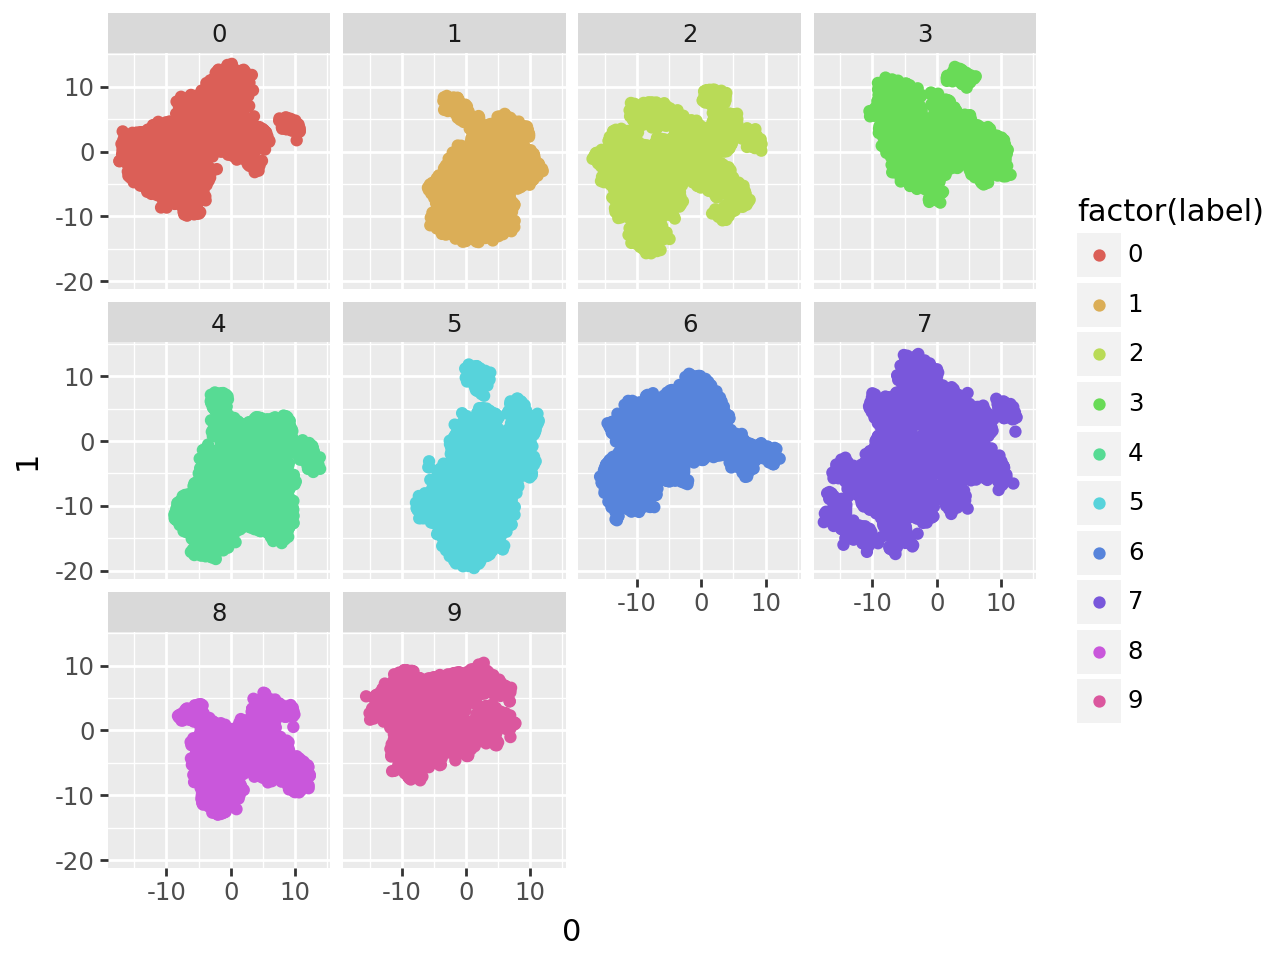

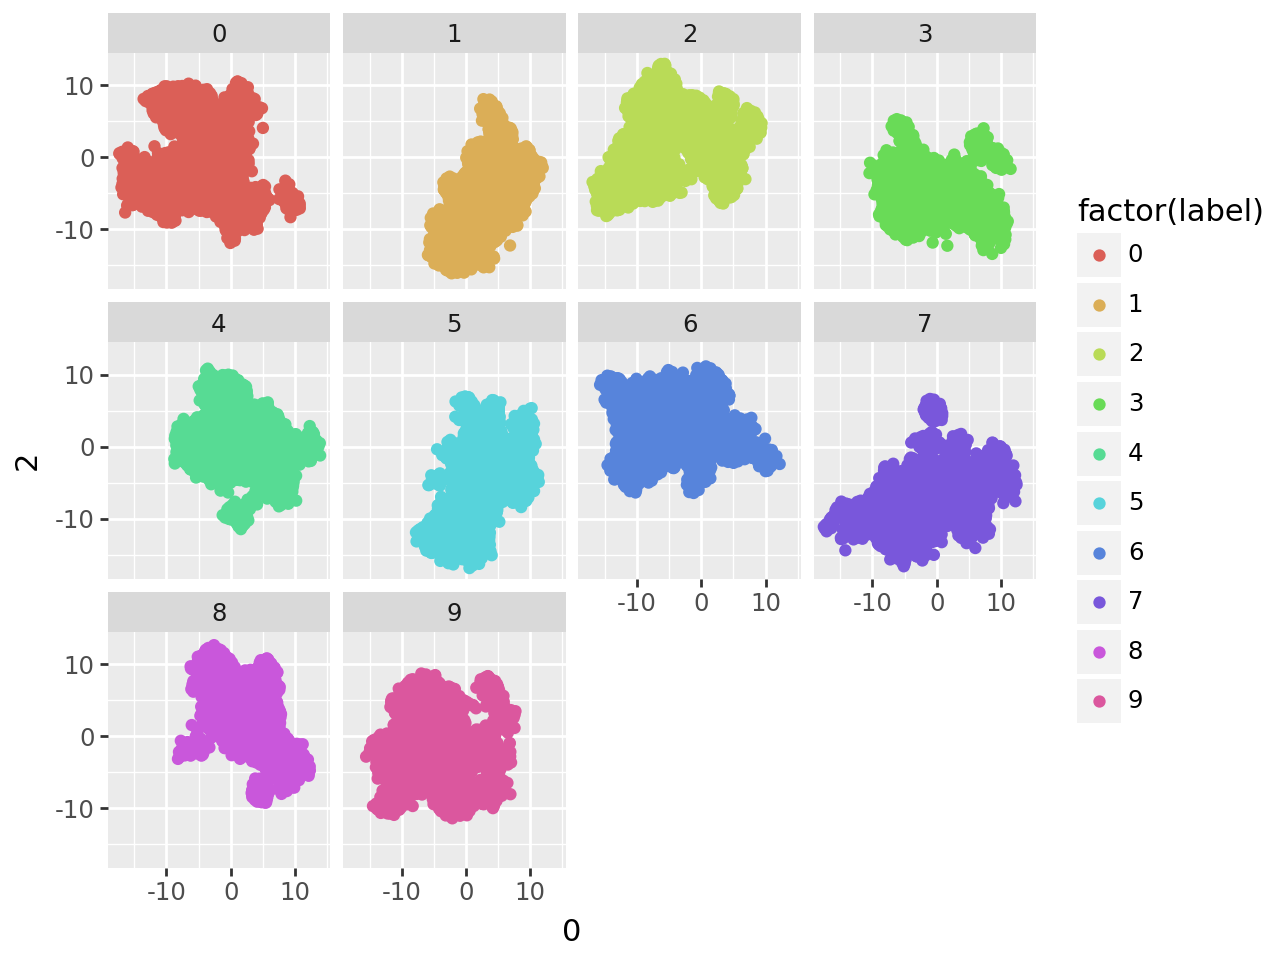

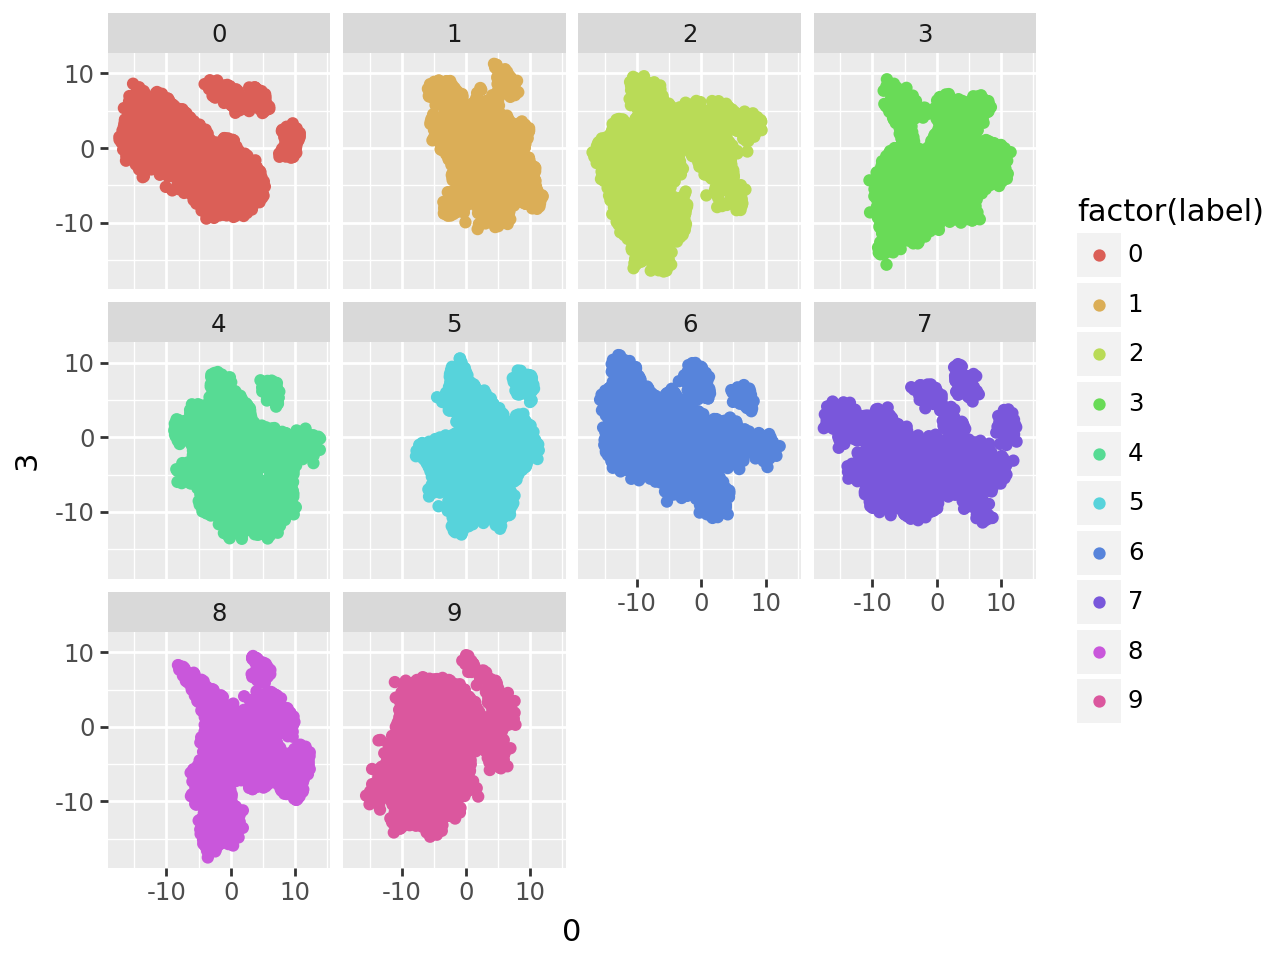

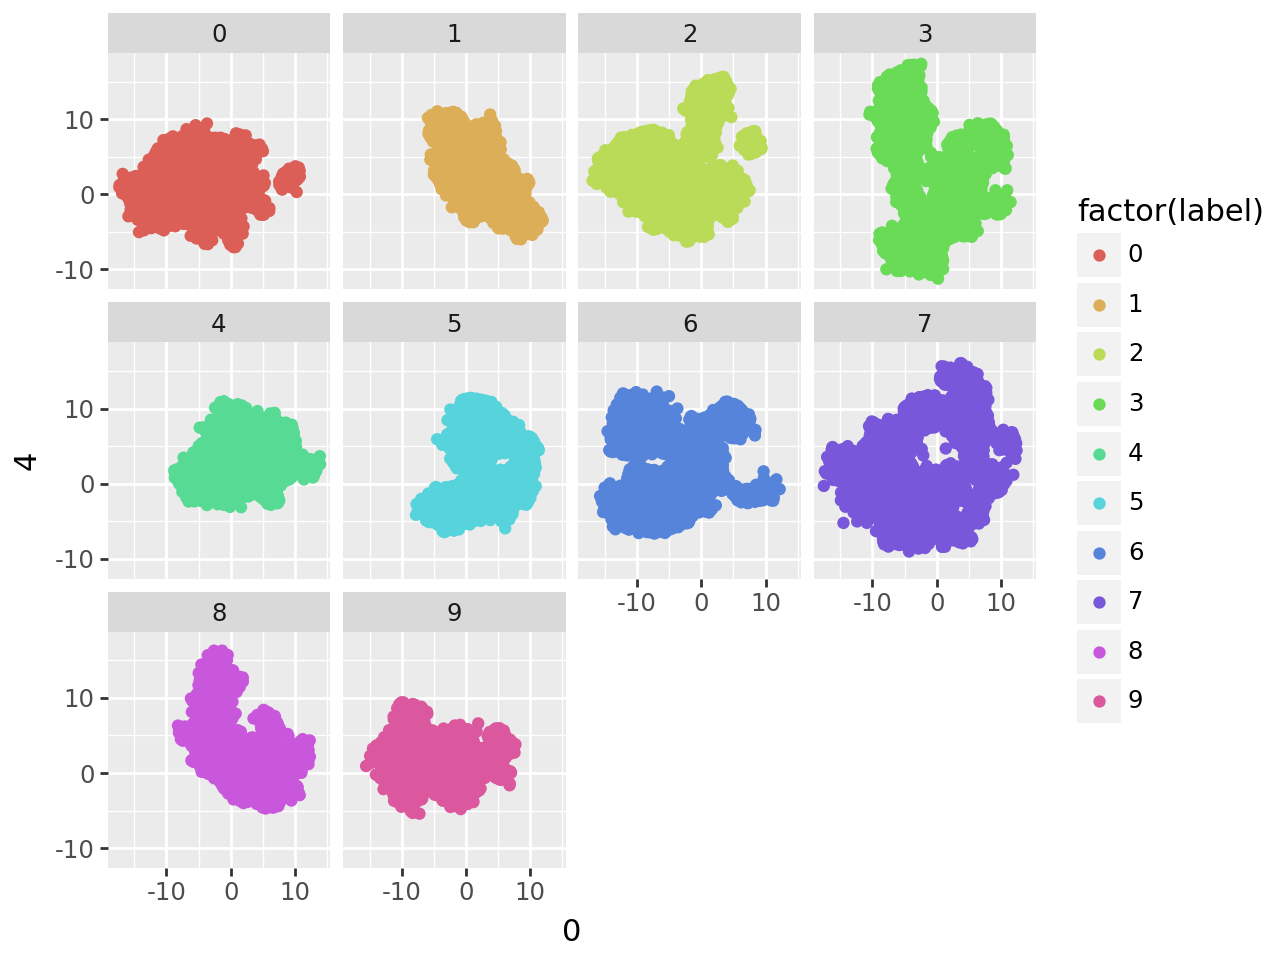

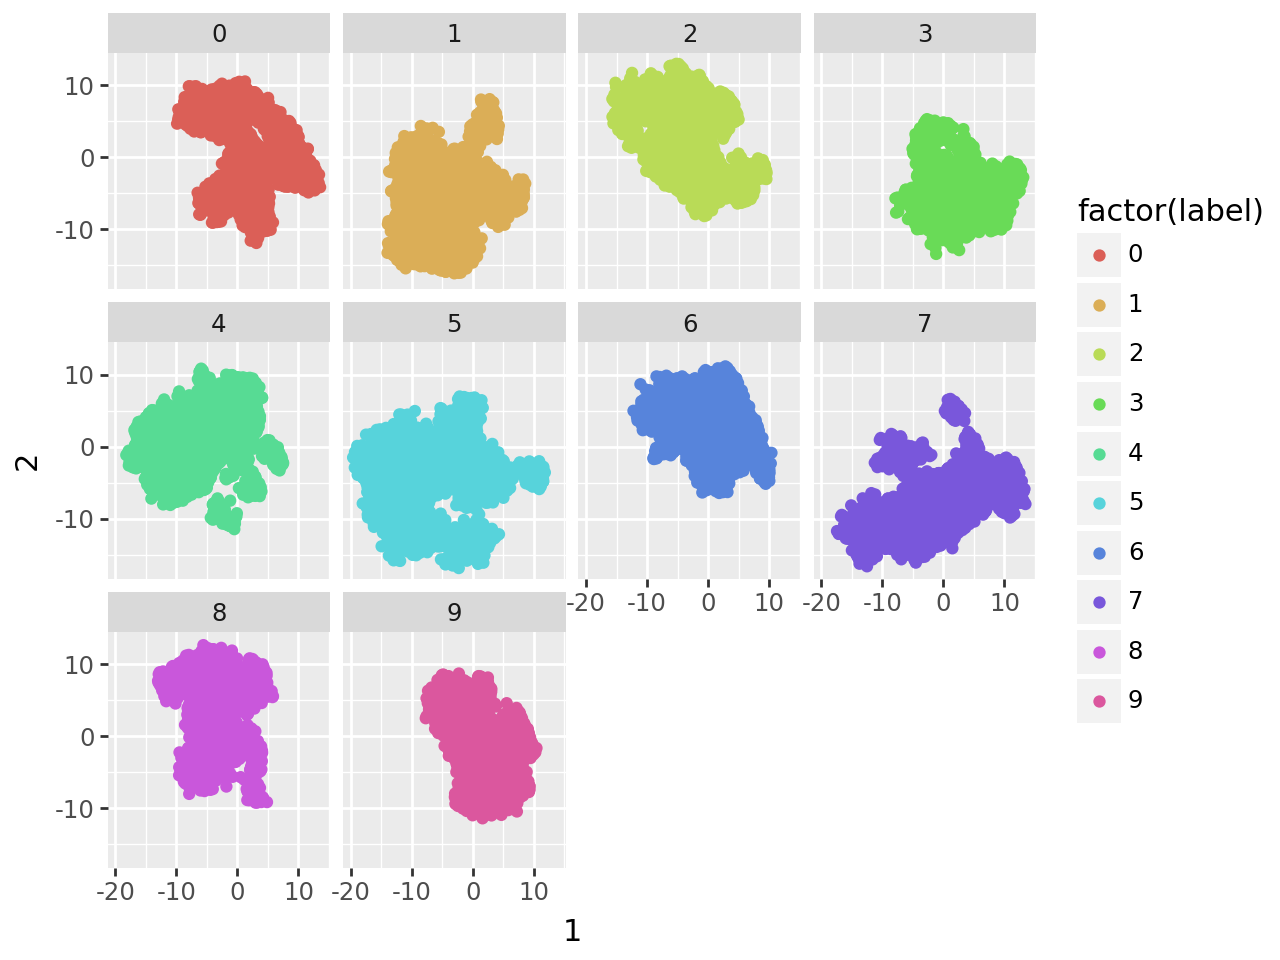

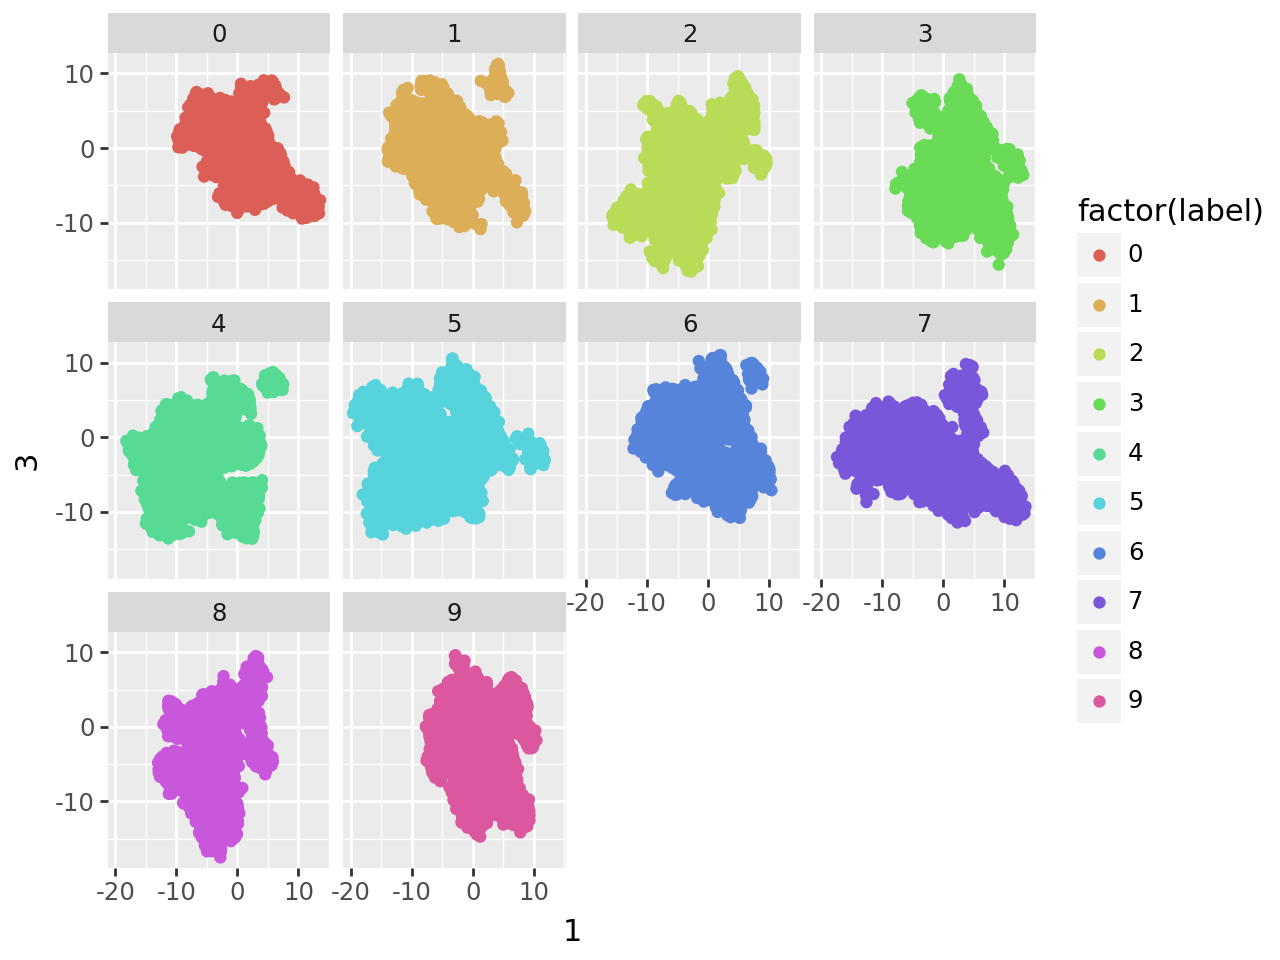

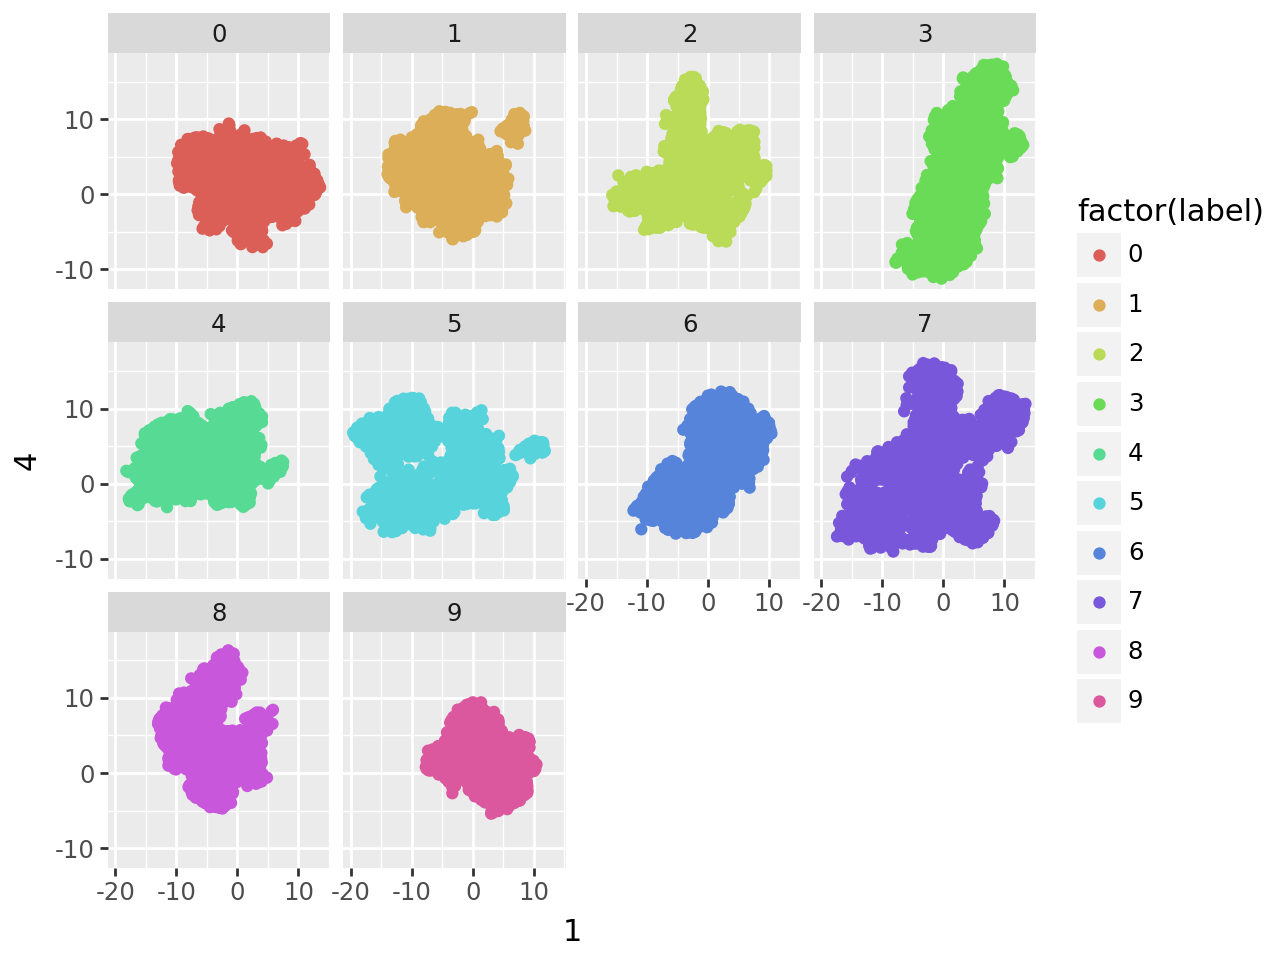

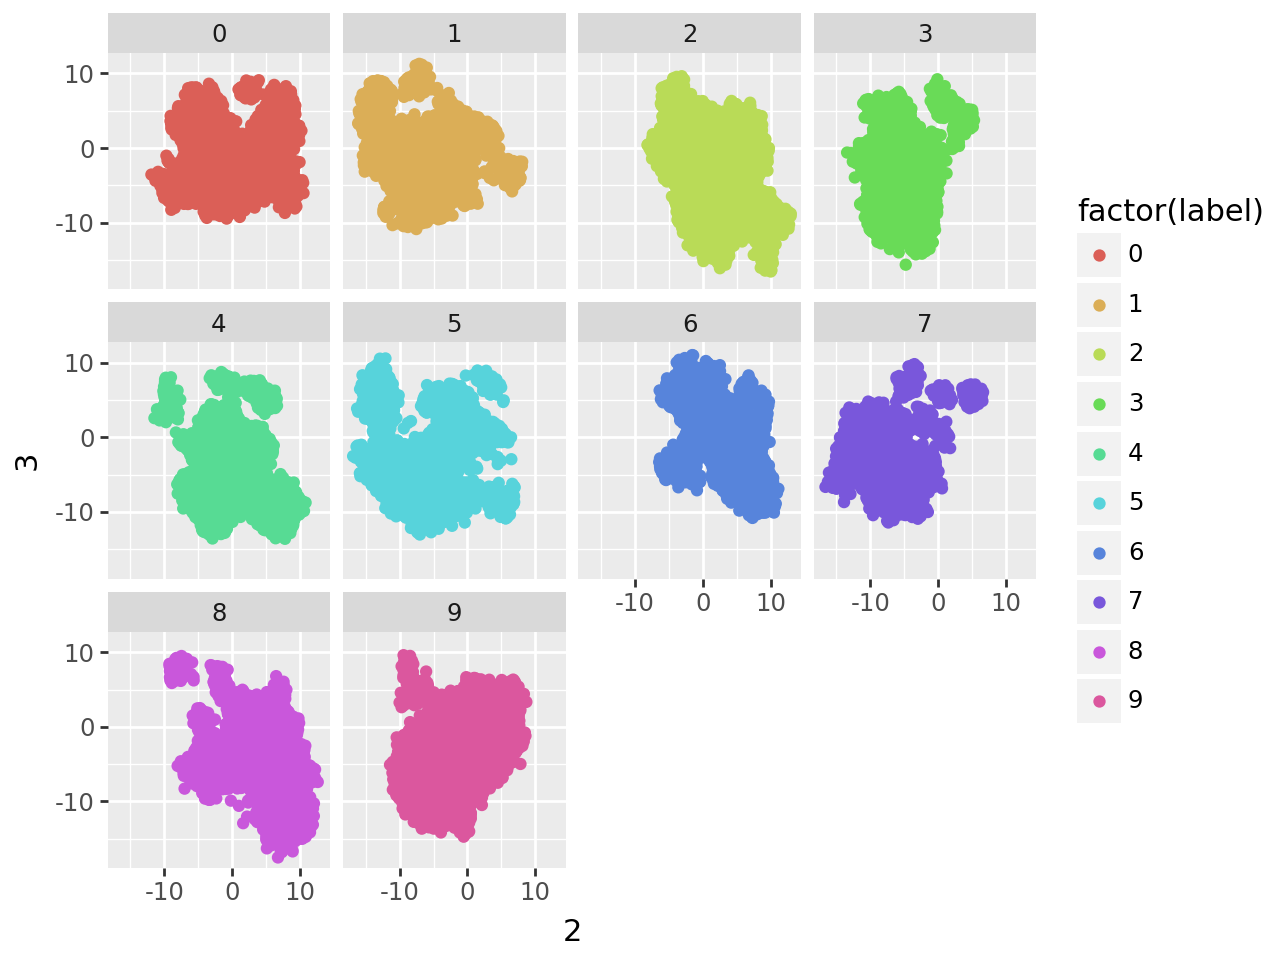

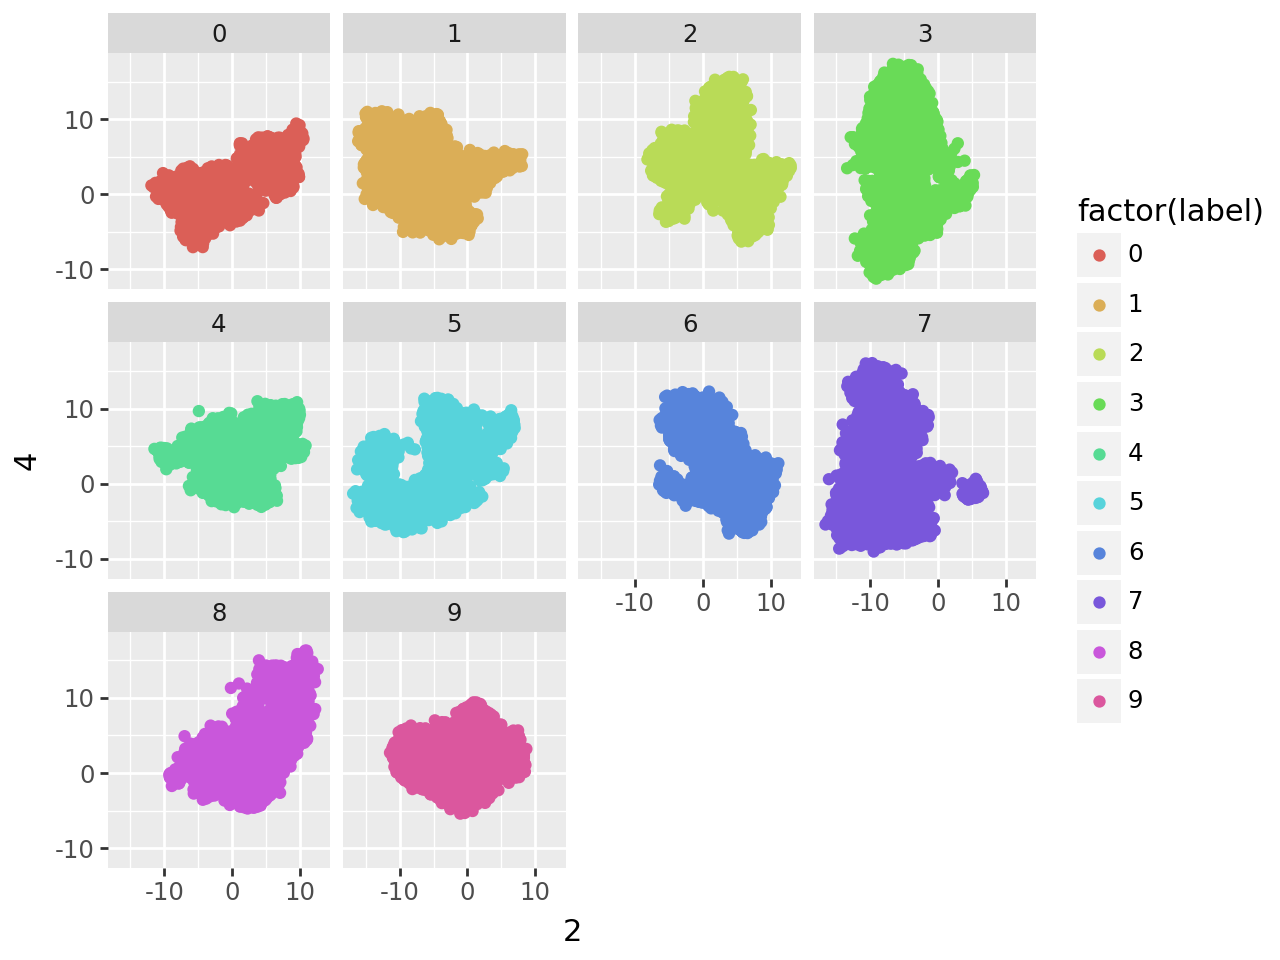

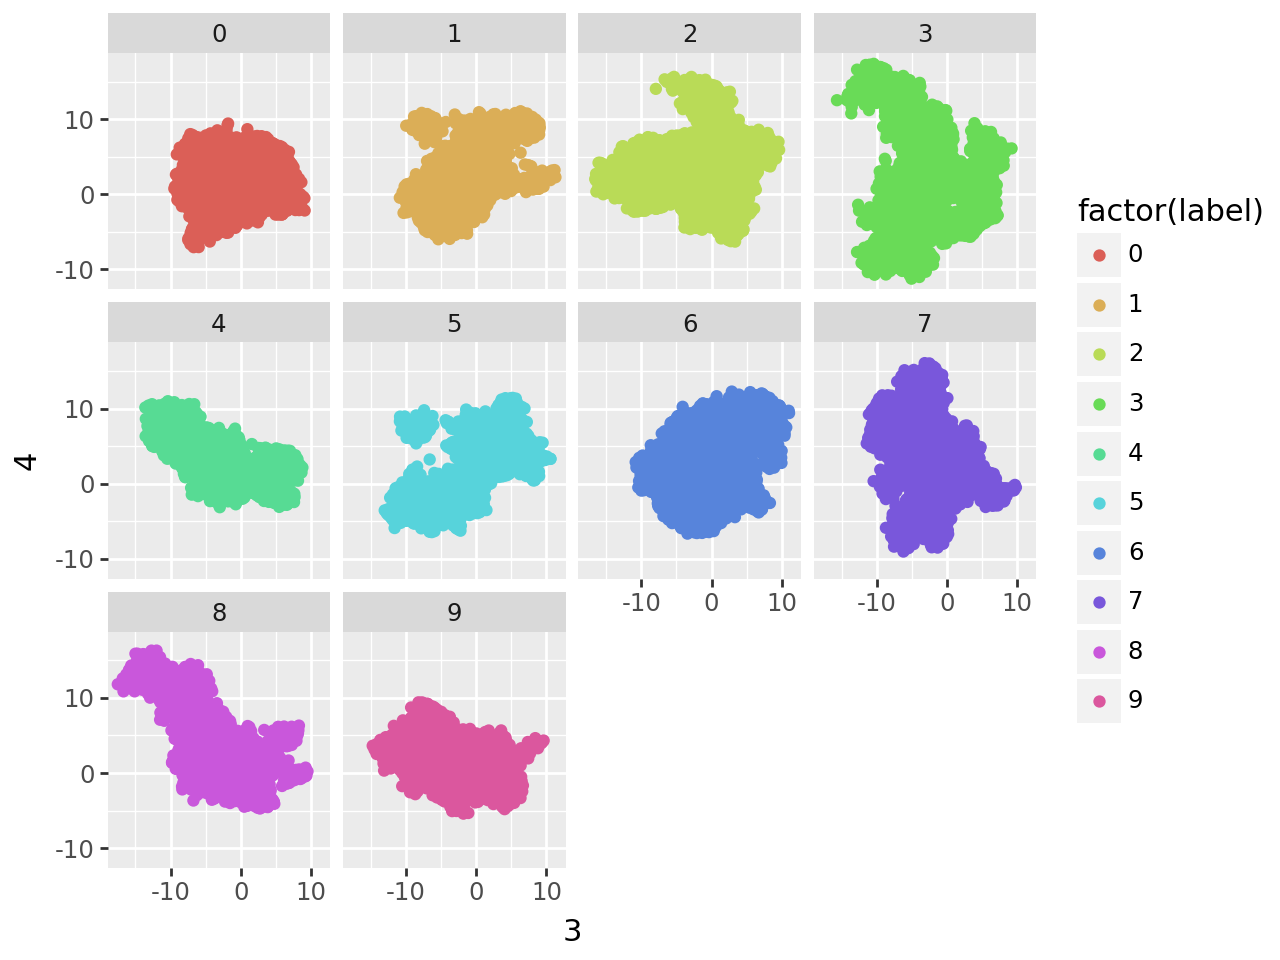

In [216]:
#ggplot(df.filter(pl.col('variable').is_in(['0', '1', '2', '3'])), aes(x='value', fill='factor(label)')) + geom_histogram() + facet_wrap('~variable')
# mlp2_posts_df.filter(pl.col('0') < -100)

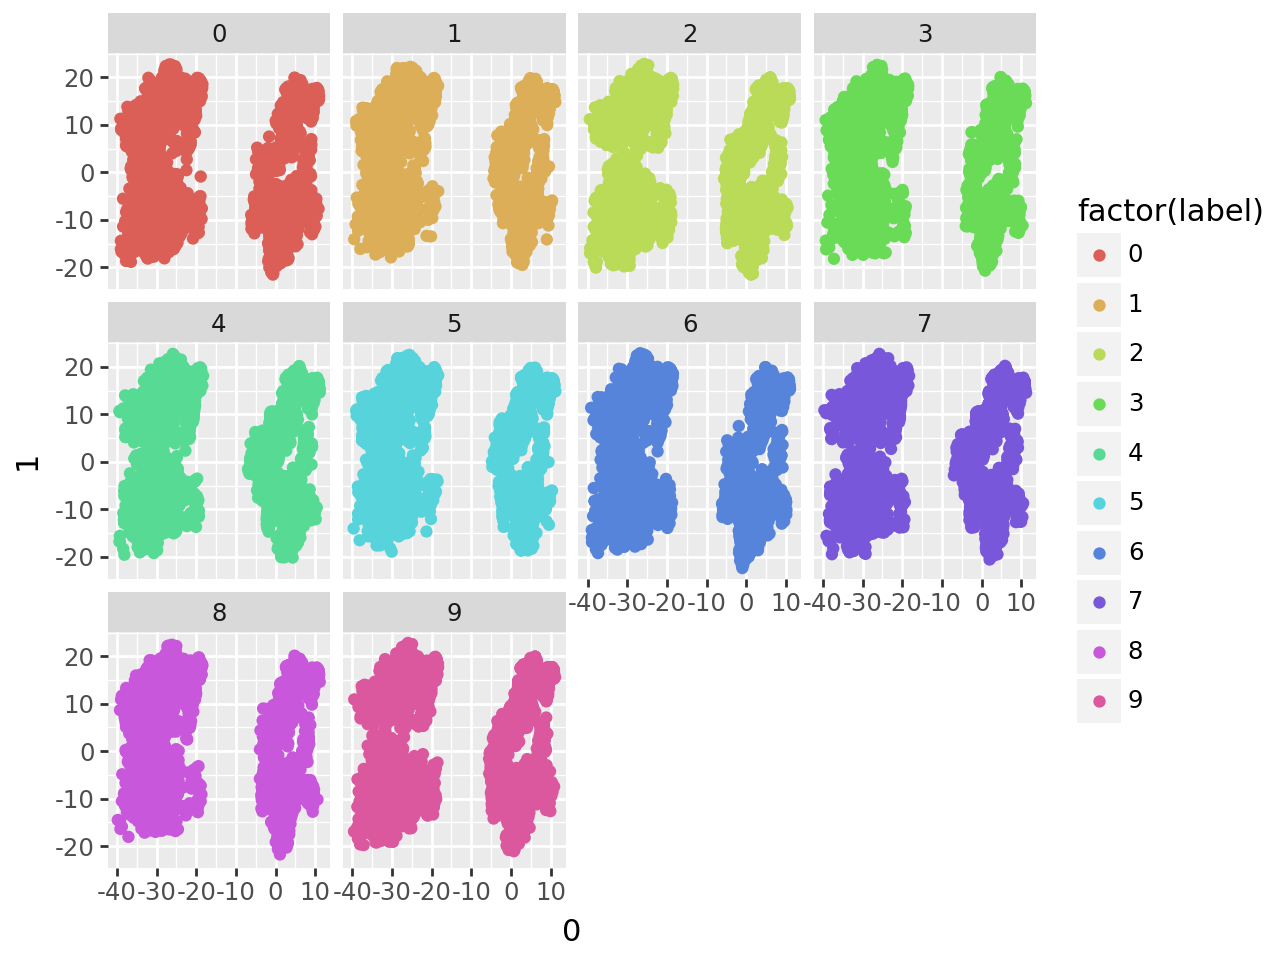

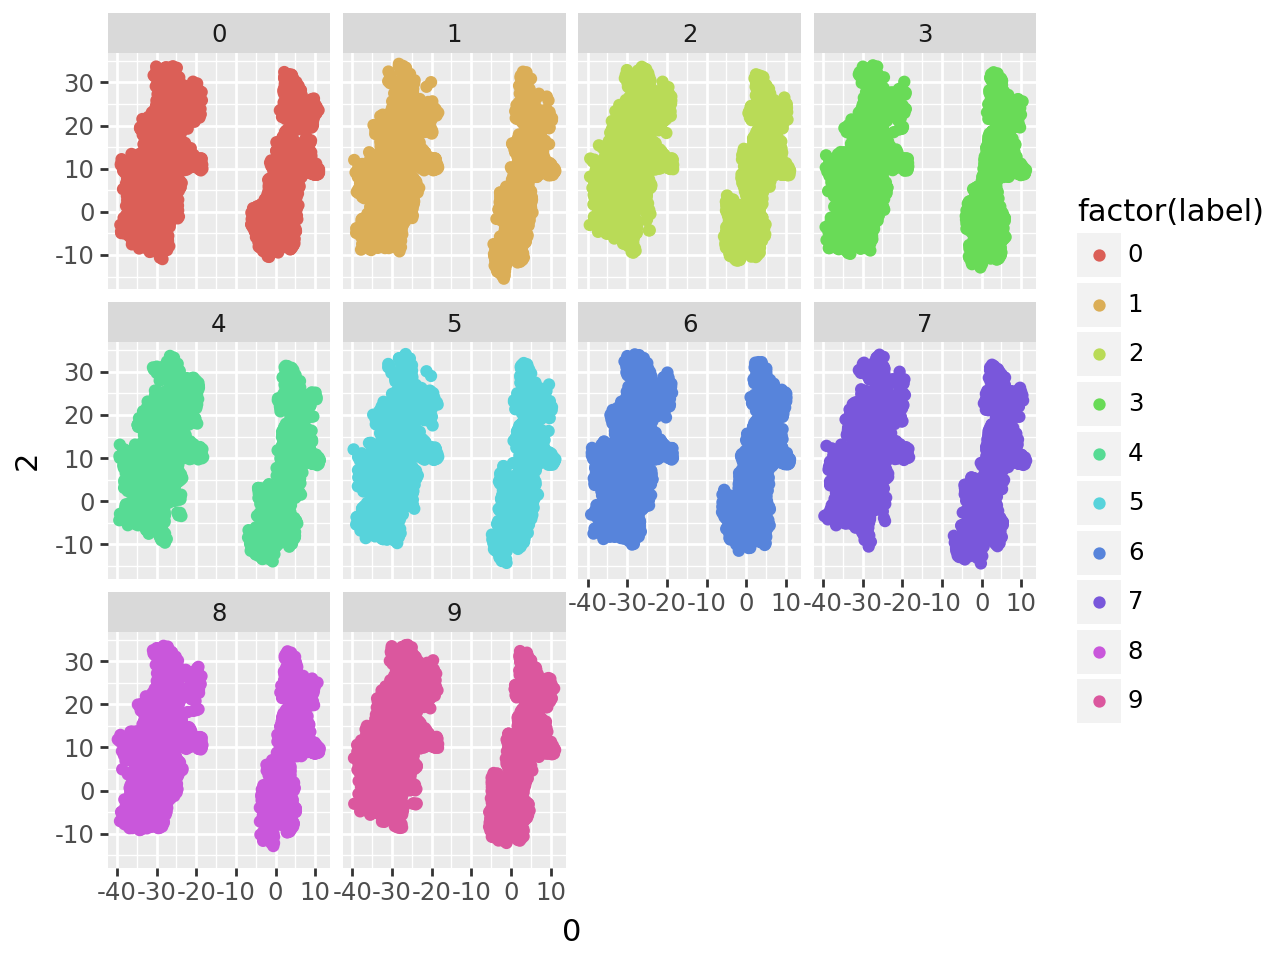

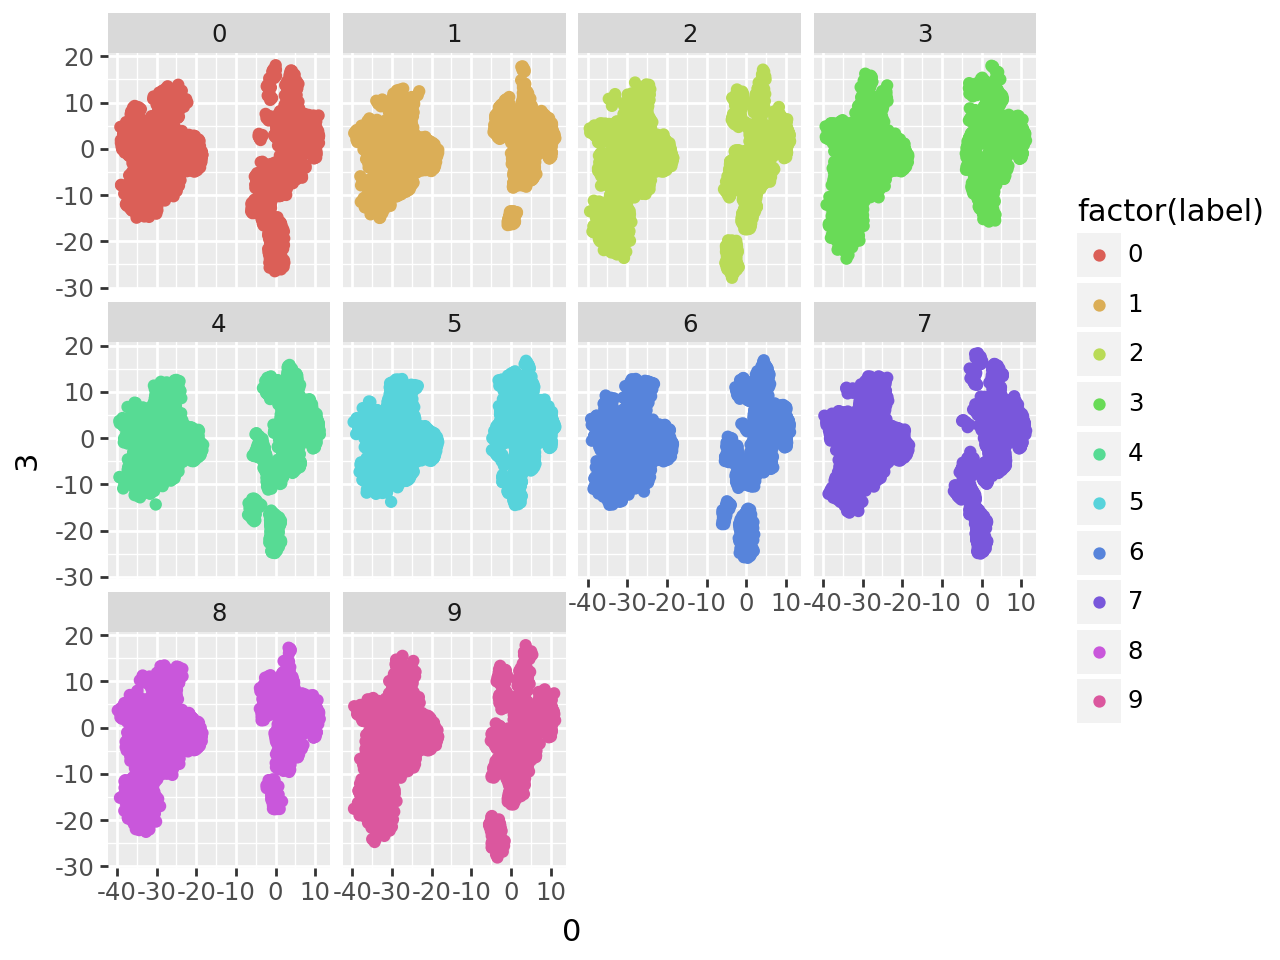

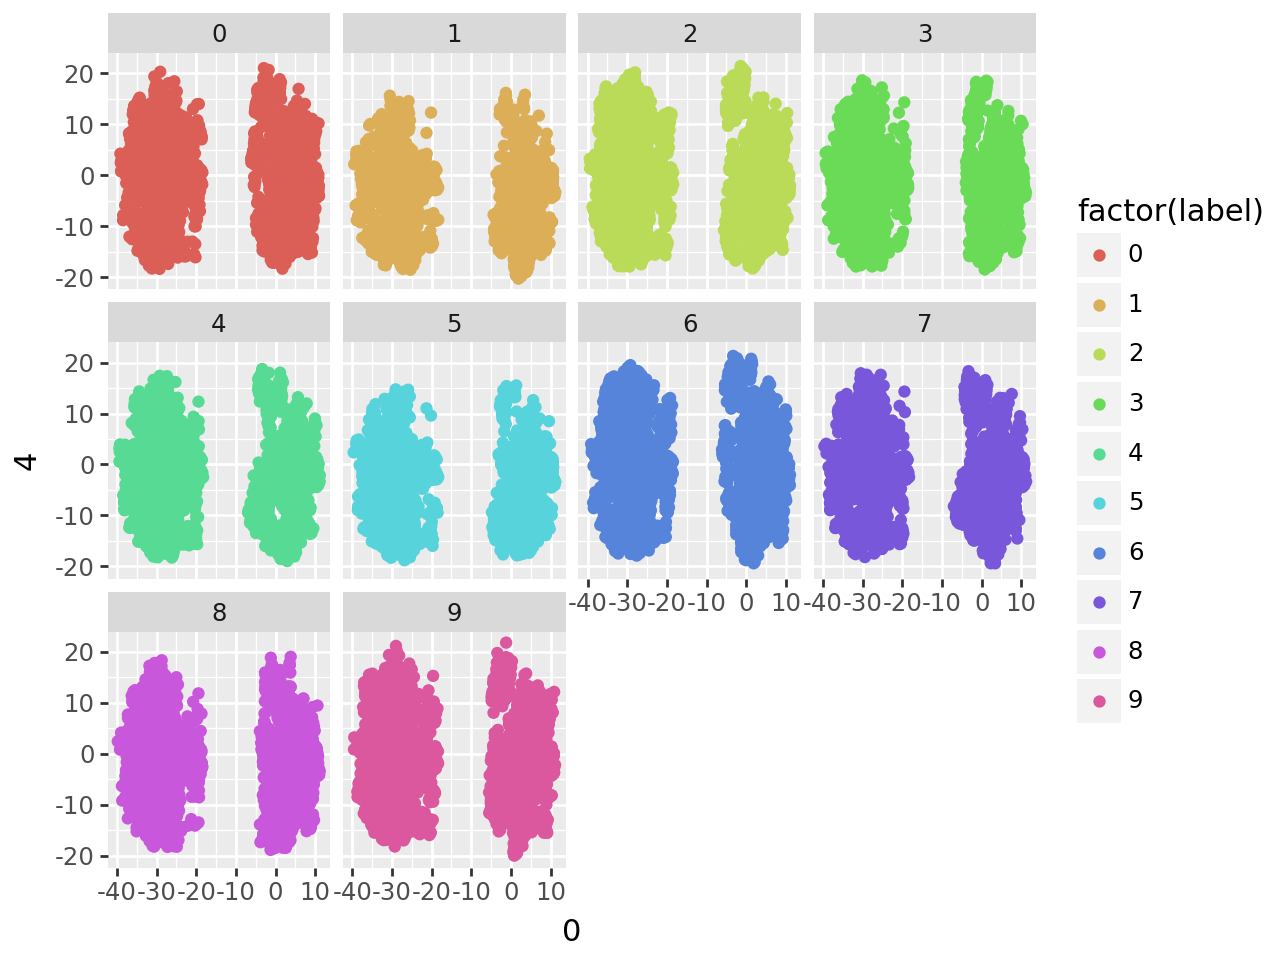

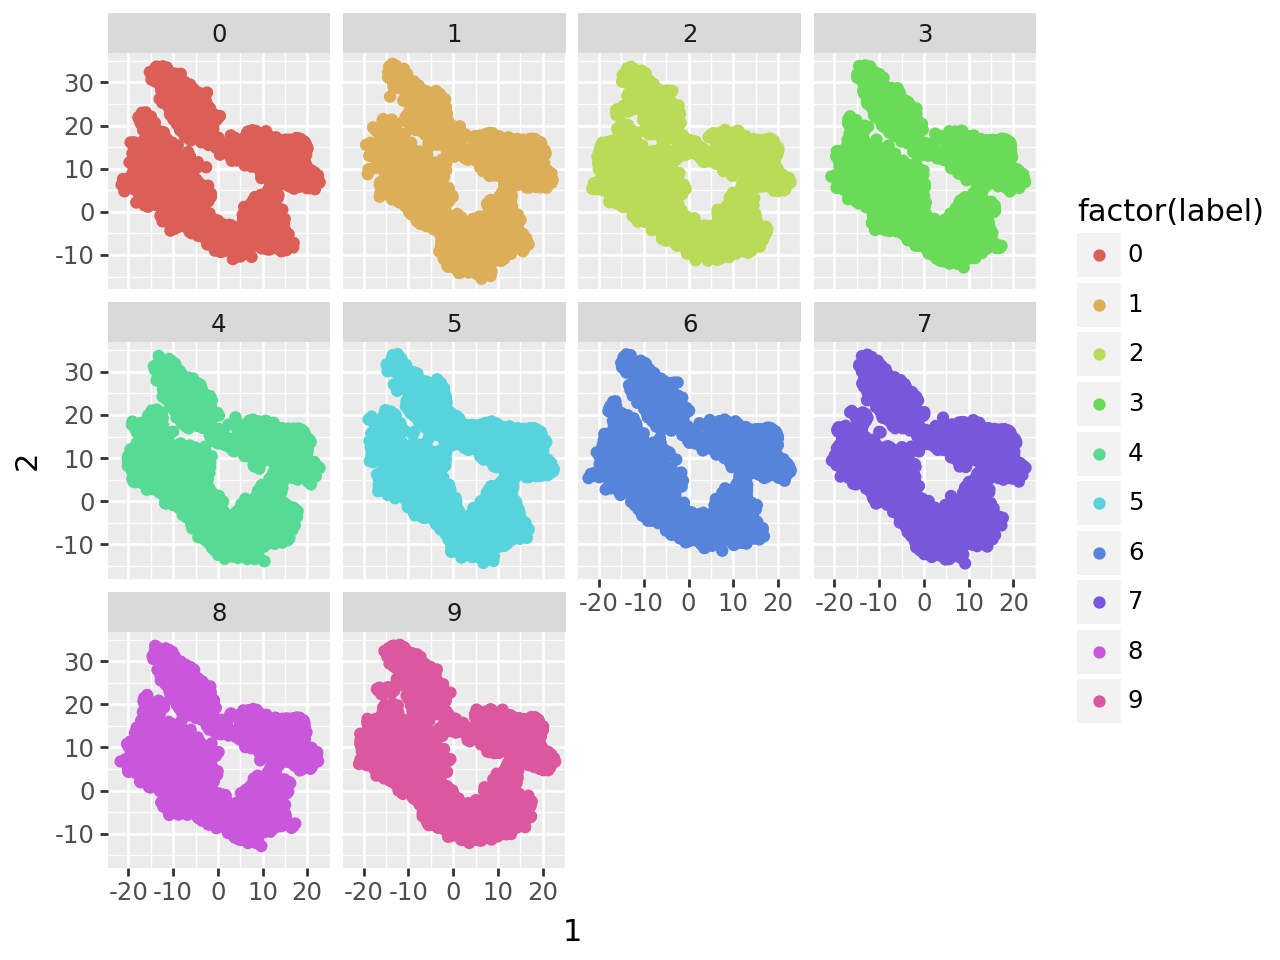

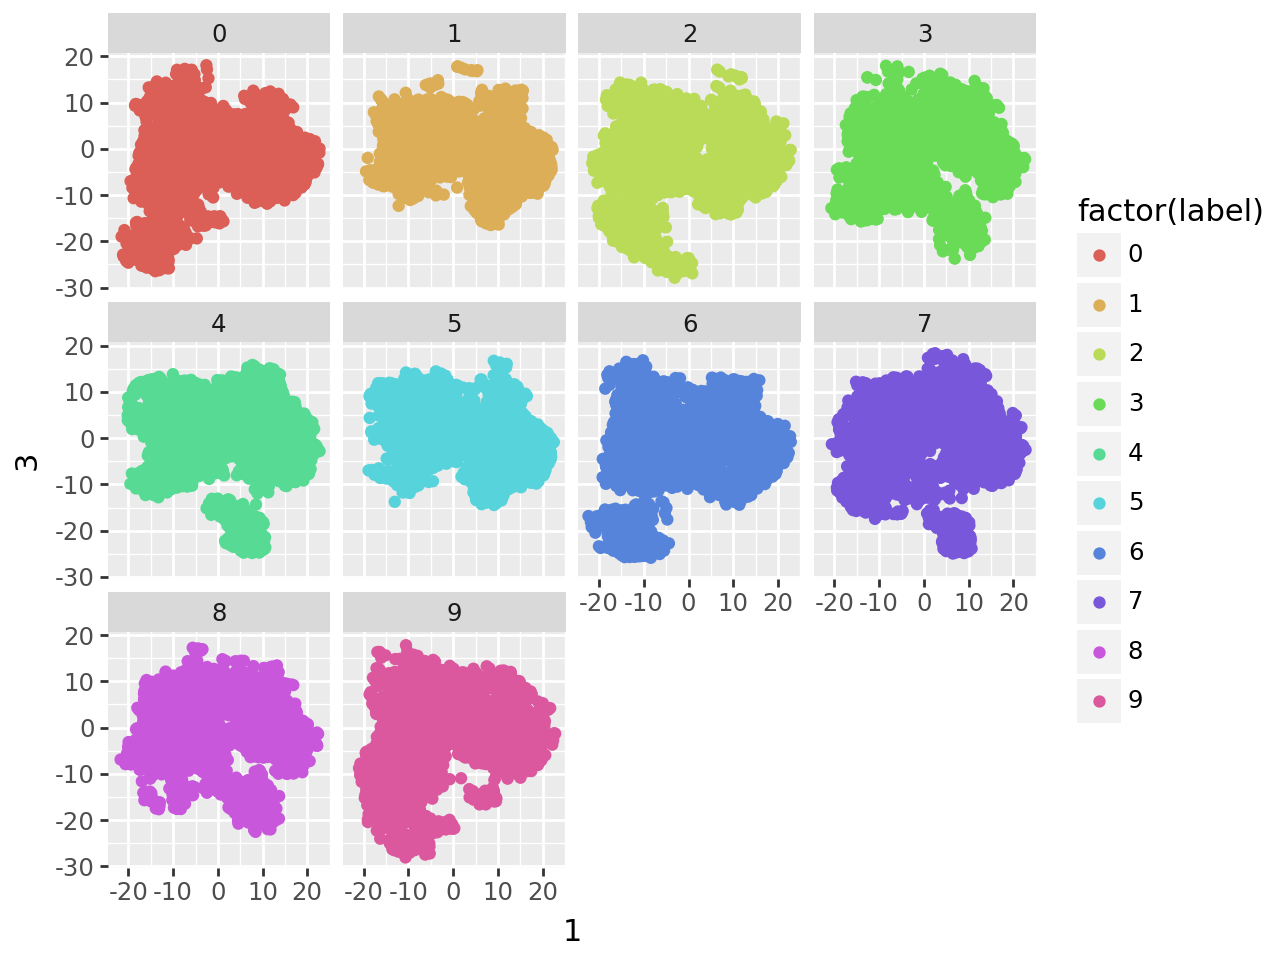

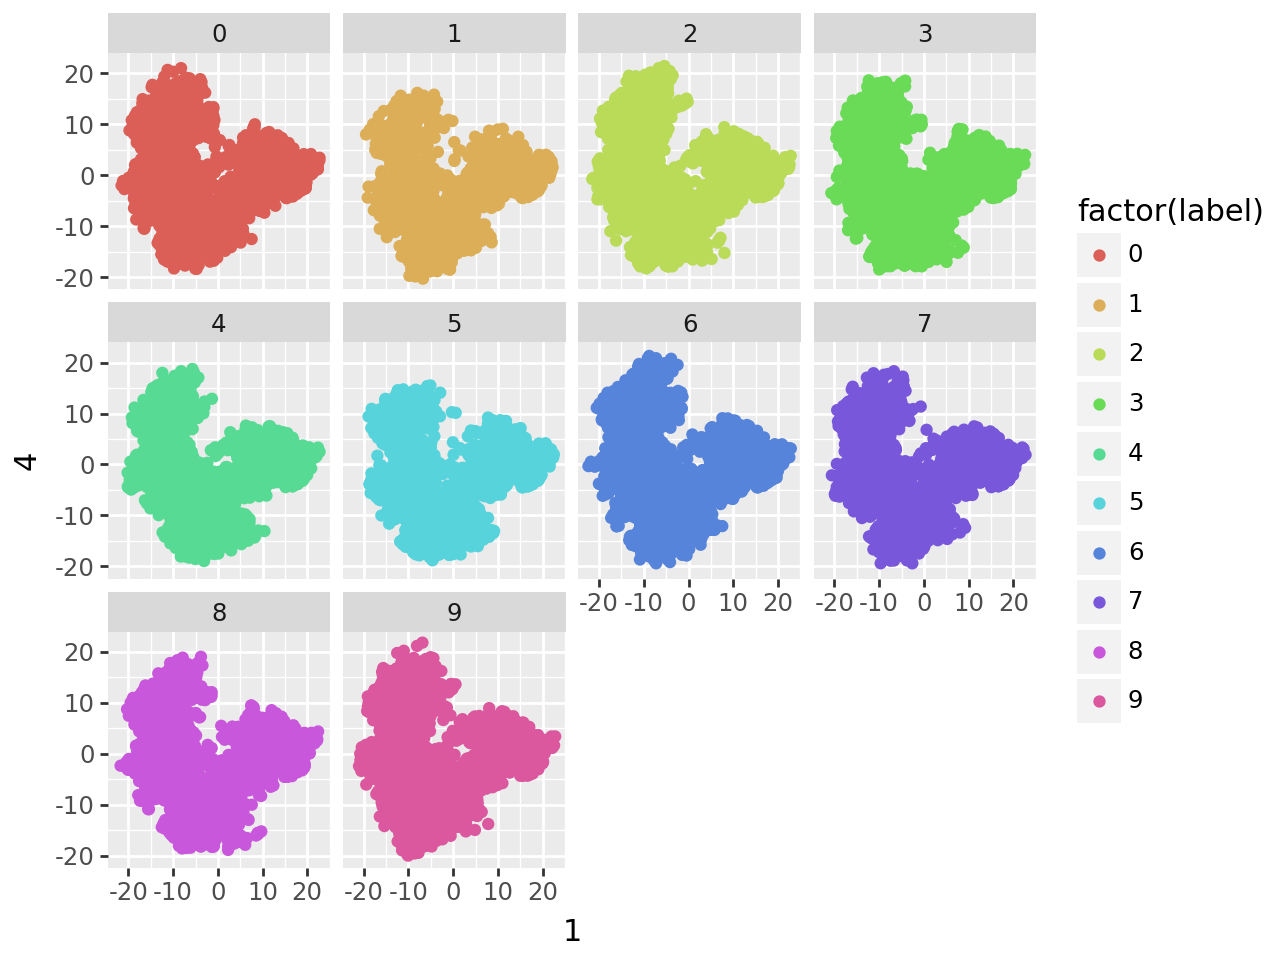

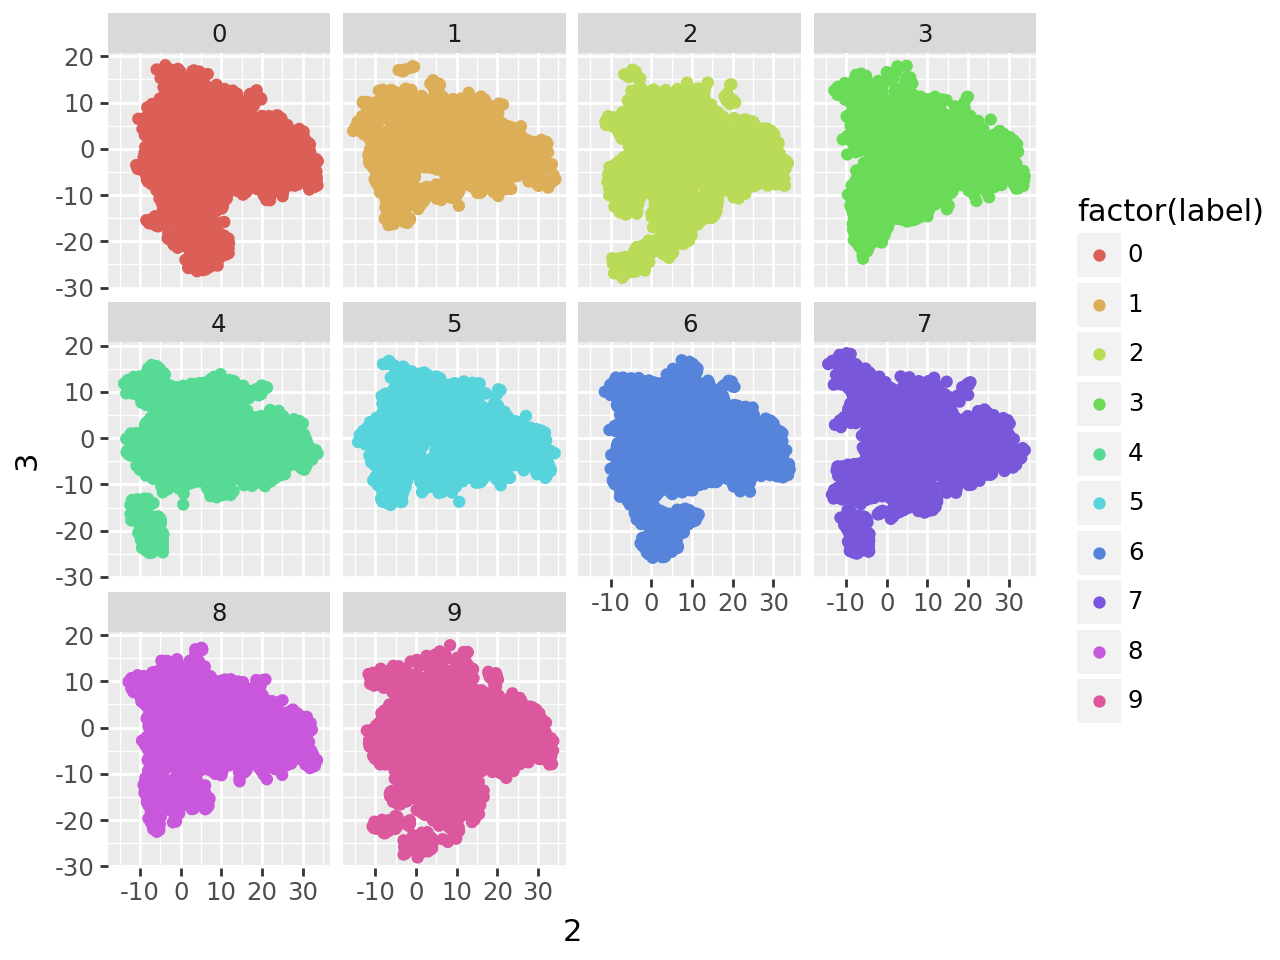

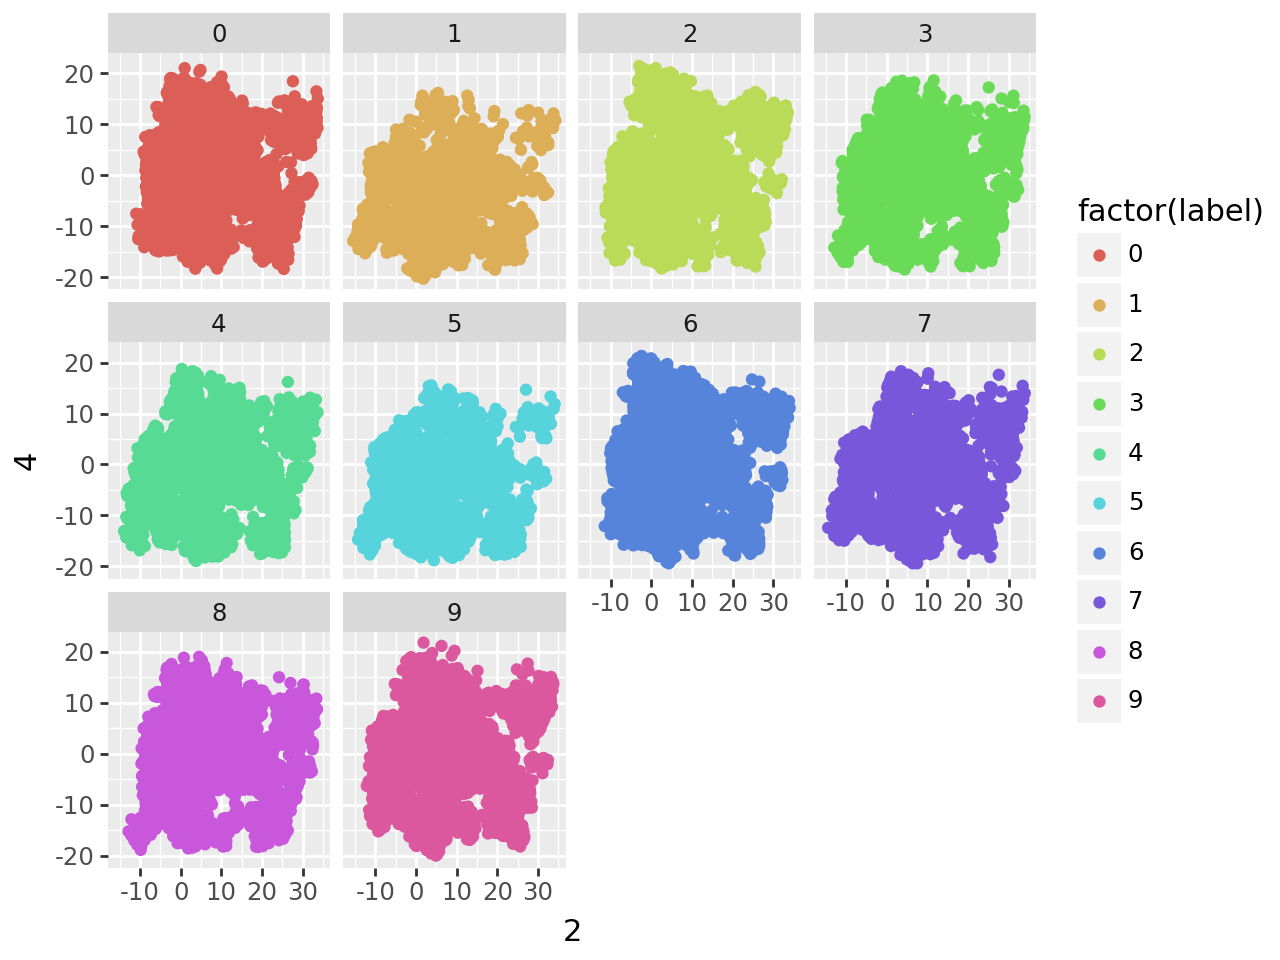

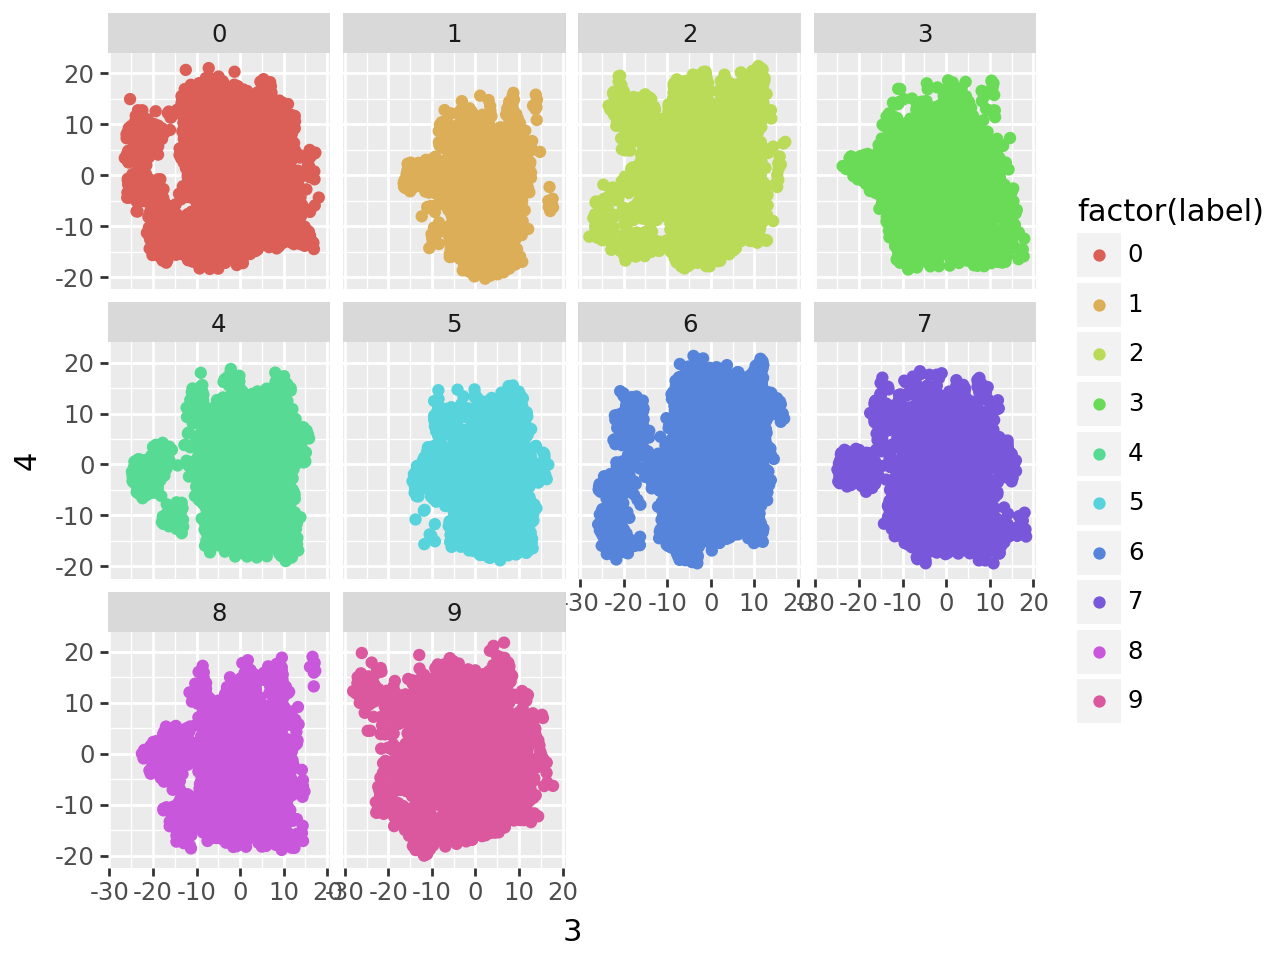

In [229]:
U_resid, S_resid, V_resid = get_pca(resid_pos16)
get_vars(S_resid)

mean = resid_pos16.mean(dim=0)
nonzero = torch.nonzero(mean).squeeze()
resid_reduced = resid_pos16[:, nonzero] @ V_resid
resid_df = pl.DataFrame(resid_reduced.detach().cpu().numpy(), schema=[str(i) for i in range(resid_reduced.shape[1])])
resid_df = pl.concat([label_df, resid_df], how='horizontal')

combs = itertools.combinations(range(5), r=2)
for c in combs:
    plot = ggplot(resid_df, aes(x=str(c[0]), y=str(c[1]), color='factor(label)')) + geom_point() + facet_wrap('~label')
    display(plot)

# Trial inputs

In [146]:
all1 = torch.ones((25), dtype=torch.int32)
all0 = torch.zeros((25), dtype=torch.int32)
all1_label = (torch.cumsum(all1, dim=0)) % 5
all0_label = torch.tensor([5,0]*12+[5], dtype=torch.int32)
print(all1_label)
print(all0_label)

# All zeros except a single one at one position
all_zero_except1 = deepcopy(all0)
all_zero_except1[8] = 1
all_zero_except1_label = actions_to_labels(all_zero_except1, dtype="int")
print(all_zero_except1_label)


# All ones except a single zero at one position
all_one_except1 = deepcopy(all1)
all_one_except1[8] = 0
all_one_except1_label = actions_to_labels(all_one_except1, dtype="int")
print(all_one_except1_label)

tensor([1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4,
        0])
tensor([5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0,
        5], dtype=torch.int32)
tensor([5, 0, 5, 0, 5, 0, 5, 0, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6,
        1], dtype=torch.int32)
tensor([1, 2, 3, 4, 0, 1, 2, 3, 8, 7, 6, 5, 9, 8, 7, 6, 5, 9, 8, 7, 6, 5, 9, 8,
        7], dtype=torch.int32)


### Early in training

In [147]:
l_all1_0, cache_all1_0 = model_0.run_with_cache(all1)
l_all0_0, cache_all0_0 = model_0.run_with_cache(all0)
pred_all1_0 = torch.argmax(l_all1_0, dim=-1).squeeze().cpu()
pred_all0_0 = torch.argmax(l_all0_0, dim=-1).squeeze().cpu()
print(pred_all0_0.shape)
print("all one labels", all1_label)
print("predicted all ones", pred_all1_0)
print("all zero labels", all0_label)
print("predicted all zeros", pred_all0_0)

l_all_zero_except1_0, c_zero_except1_0 = model_0.run_with_cache(all_zero_except1)
l_all_one_except1_0 , c_all_one_except1_0 = model_0.run_with_cache(all_one_except1)
pred_all_zero_except1_0 = torch.argmax(l_all_zero_except1_0, dim=-1).squeeze().cpu()
pred_all_one_except1_0 = torch.argmax(l_all_one_except1_0, dim=-1).squeeze().cpu()
print(all_zero_except1_label)
print("predicted all 0s except 1", pred_all_zero_except1_0)
print(all_one_except1_label)
print("predicted all 1s except 1", pred_all_one_except1_0)

torch.Size([25])
all one labels tensor([1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4,
        0])
predicted all ones tensor([1, 2, 3, 4, 3, 2, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3])
all zero labels tensor([5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0,
        5], dtype=torch.int32)
predicted all zeros tensor([5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 9, 5, 9, 5, 9, 5, 9, 9, 9, 9, 9,
        9])
tensor([5, 0, 5, 0, 5, 0, 5, 0, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6,
        1], dtype=torch.int32)
predicted all 0s except 1 tensor([5, 0, 5, 0, 5, 0, 5, 0, 1, 0, 5, 0, 5, 0, 1, 9, 5, 9, 5, 9, 1, 9, 9, 9,
        9])
tensor([1, 2, 3, 4, 0, 1, 2, 3, 8, 7, 6, 5, 9, 8, 7, 6, 5, 9, 8, 7, 6, 5, 9, 8,
        7], dtype=torch.int32)
predicted all 1s except 1 tensor([1, 2, 3, 4, 3, 2, 3, 0, 2, 8, 2, 8, 2, 2, 6, 8, 2, 2, 2, 2, 2, 2, 8, 2,
        2])


### Form 1

In [149]:
l_all1_1, cache_all1_1 = model_1.run_with_cache(all1)
l_all0_1, cache_all0_1 = model_1.run_with_cache(all0)
pred_all1_1 = torch.argmax(l_all1_1, dim=-1).squeeze().cpu()
pred_all0_1 = torch.argmax(l_all0_1, dim=-1).squeeze().cpu()
print(pred_all0_1.shape)
print("all one labels", all1_label)
print("predicted all ones", pred_all1_1)
print("all zero labels", all0_label)
print("predicted all zeros", pred_all0_1)

l_all_zero_except1_1, c_zero_except1_1 = model_1.run_with_cache(all_zero_except1)
l_all_one_except1_1 , c_all_one_except1_1 = model_1.run_with_cache(all_one_except1)
pred_all_zero_except1_1 = torch.argmax(l_all_zero_except1_1, dim=-1).squeeze().cpu()
pred_all_one_except1_1 = torch.argmax(l_all_one_except1_1, dim=-1).squeeze().cpu()
print(all_zero_except1_label)
print("predicted all 0s except 1", pred_all_zero_except1_1)
print(all_one_except1_label)
print("predicted all 1s except 1", pred_all_one_except1_1)

torch.Size([25])
all one labels tensor([1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4,
        0])
predicted all ones tensor([1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 9, 5, 9, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3])
all zero labels tensor([5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0,
        5], dtype=torch.int32)
predicted all zeros tensor([5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0,
        5])
tensor([5, 0, 5, 0, 5, 0, 5, 0, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6,
        1], dtype=torch.int32)
predicted all 0s except 1 tensor([5, 0, 5, 0, 5, 0, 5, 0, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6,
        1])
tensor([1, 2, 3, 4, 0, 1, 2, 3, 8, 7, 6, 5, 9, 8, 7, 6, 5, 9, 8, 7, 6, 5, 9, 8,
        7], dtype=torch.int32)
predicted all 1s except 1 tensor([1, 2, 3, 4, 0, 1, 2, 3, 8, 7, 6, 0, 4, 8, 9, 8, 7, 8, 0, 8, 0, 8, 0, 8,
        0])


### Form 2

In [150]:
l_all1_2, cache_all1_2 = model_2.run_with_cache(all1)
l_all0_2, cache_all0_2 = model_2.run_with_cache(all0)
pred_all1_2 = torch.argmax(l_all1_2, dim=-1).squeeze().cpu()
pred_all0_2 = torch.argmax(l_all0_2, dim=-1).squeeze().cpu()
print(pred_all0_2.shape)
print("all one labels", all1_label)
print("predicted all ones", pred_all1_2)
print("all zero labels", all0_label)
print("predicted all zeros", pred_all0_2)

l_all_zero_except1_2, c_zero_except1_2 = model_2.run_with_cache(all_zero_except1)
l_all_one_except1_2 , c_all_one_except1_2 = model_2.run_with_cache(all_one_except1)
pred_all_zero_except1_2 = torch.argmax(l_all_zero_except1_2, dim=-1).squeeze().cpu()
pred_all_one_except1_2 = torch.argmax(l_all_one_except1_2, dim=-1).squeeze().cpu()
print(all_zero_except1_label)
print("predicted all 0s except 1", pred_all_zero_except1_2)
print(all_one_except1_label)
print("predicted all 1s except 1", pred_all_one_except1_2)

torch.Size([25])
all one labels tensor([1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4,
        0])
predicted all ones tensor([1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 3, 9, 1, 9, 1, 9, 1, 9, 1, 9,
        1])
all zero labels tensor([5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0,
        5], dtype=torch.int32)
predicted all zeros tensor([5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0,
        5])
tensor([5, 0, 5, 0, 5, 0, 5, 0, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6,
        1], dtype=torch.int32)
predicted all 0s except 1 tensor([5, 0, 5, 0, 5, 0, 5, 0, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6,
        1])
tensor([1, 2, 3, 4, 0, 1, 2, 3, 8, 7, 6, 5, 9, 8, 7, 6, 5, 9, 8, 7, 6, 5, 9, 8,
        7], dtype=torch.int32)
predicted all 1s except 1 tensor([1, 2, 3, 4, 0, 1, 2, 3, 8, 7, 6, 5, 9, 8, 7, 8, 9, 0, 1, 0, 1, 0, 1, 9,
        1])


### Form 3

In [151]:
l_all1_3, cache_all1_3 = model_3.run_with_cache(all1)
l_all0_3, cache_all0_3 = model_3.run_with_cache(all0)
pred_all1_3 = torch.argmax(l_all1_3, dim=-1).squeeze().cpu()
pred_all0_3 = torch.argmax(l_all0_3, dim=-1).squeeze().cpu()
print(pred_all0_3.shape)
print("all one labels", all1_label)
print("predicted all 1s", pred_all1_3)
print("all zero labels", all0_label)
print("predicted all 0s", pred_all0_3)

l_all_zero_except1_3, c_zero_except1_3 = model_3.run_with_cache(all_zero_except1)
l_all_one_except1_3 , c_all_one_except1_3 = model_3.run_with_cache(all_one_except1)
pred_all_zero_except1_3 = torch.argmax(l_all_zero_except1_3, dim=-1).squeeze().cpu()
pred_all_one_except1_3 = torch.argmax(l_all_one_except1_3, dim=-1).squeeze().cpu()
print(all_zero_except1_label)
print("predicted all 0s except 1", pred_all_zero_except1_3)
print(all_one_except1_label)
print("predicted all 1s except 1", pred_all_one_except1_3)

torch.Size([25])
all one labels tensor([1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4,
        0])
predicted all 1s tensor([1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 4, 0, 0, 1,
        0])
all zero labels tensor([5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0,
        5], dtype=torch.int32)
predicted all 0s tensor([5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0,
        5])
tensor([5, 0, 5, 0, 5, 0, 5, 0, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6,
        1], dtype=torch.int32)
predicted all 0s except 1 tensor([5, 0, 5, 0, 5, 0, 5, 0, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6,
        1])
tensor([1, 2, 3, 4, 0, 1, 2, 3, 8, 7, 6, 5, 9, 8, 7, 6, 5, 9, 8, 7, 6, 5, 9, 8,
        7], dtype=torch.int32)
predicted all 1s except 1 tensor([1, 2, 3, 4, 0, 1, 2, 3, 8, 7, 6, 5, 9, 8, 7, 6, 5, 9, 8, 2, 8, 0, 8, 1,
        0])


### Form 4

In [152]:
l_all1_4, cache_all1_4 = model_4.run_with_cache(all1)
l_all0_4, cache_all0_4 = model_4.run_with_cache(all0)
pred_all1_4 = torch.argmax(l_all1_4, dim=-1).squeeze().cpu()
pred_all0_4 = torch.argmax(l_all0_4, dim=-1).squeeze().cpu()
print(pred_all0_4.shape)
print("all one labels", all1_label)
print("predicted all 1s", pred_all1_4)
print("all zero labels", all0_label)
print("predicted all 0s", pred_all0_4)

l_all_zero_except1_4, c_zero_except1_4 = model_4.run_with_cache(all_zero_except1)
l_all_one_except1_4 , c_all_one_except1_4 = model_4.run_with_cache(all_one_except1)
pred_all_zero_except1_4 = torch.argmax(l_all_zero_except1_4, dim=-1).squeeze().cpu()
pred_all_one_except1_4 = torch.argmax(l_all_one_except1_4, dim=-1).squeeze().cpu()
print(all_zero_except1_label)
print("predicted all 0s except 1", pred_all_zero_except1_4)
print(all_one_except1_label)
print("predicted all 1s except 1", pred_all_one_except1_4)

torch.Size([25])
all one labels tensor([1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4,
        0])
predicted all 1s tensor([1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 8, 4, 8,
        4])
all zero labels tensor([5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0,
        5], dtype=torch.int32)
predicted all 0s tensor([5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0,
        5])
tensor([5, 0, 5, 0, 5, 0, 5, 0, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6,
        1], dtype=torch.int32)
predicted all 0s except 1 tensor([5, 0, 5, 0, 5, 0, 5, 0, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6,
        1])
tensor([1, 2, 3, 4, 0, 1, 2, 3, 8, 7, 6, 5, 9, 8, 7, 6, 5, 9, 8, 7, 6, 5, 9, 8,
        7], dtype=torch.int32)
predicted all 1s except 1 tensor([1, 2, 3, 4, 0, 1, 2, 3, 8, 7, 6, 5, 9, 8, 7, 6, 5, 9, 8, 7, 6, 2, 6, 4,
        4])


### End of training

In [153]:
l_all1_5, cache_all1_5 = model_5.run_with_cache(all1)
l_all0_5, cache_all0_5 = model_5.run_with_cache(all0)
pred_all1_5 = torch.argmax(l_all1_5, dim=-1).squeeze().cpu()
pred_all0_5 = torch.argmax(l_all0_5, dim=-1).squeeze().cpu()
print(pred_all0_5.shape)
print("all one labels", all1_label)
print("predicted all 1s", pred_all1_5)
print("all zero labels", all0_label)
print("predicted all 0s", pred_all0_5)

l_all_zero_except1_5, c_zero_except1_5 = model_5.run_with_cache(all_zero_except1)
l_all_one_except1_5 , c_all_one_except1_5 = model_5.run_with_cache(all_one_except1)
pred_all_zero_except1_5 = torch.argmax(l_all_zero_except1_5, dim=-1).squeeze().cpu()
pred_all_one_except1_5 = torch.argmax(l_all_one_except1_5, dim=-1).squeeze().cpu()
print(all_zero_except1_label)
print("predicted all 0s except 1", pred_all_zero_except1_5)
print(all_one_except1_label)
print("predicted all 1s except 1", pred_all_one_except1_5)

torch.Size([25])
all one labels tensor([1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4,
        0])
predicted all 1s tensor([1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 0, 1, 8,
        0])
all zero labels tensor([5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0,
        5], dtype=torch.int32)
predicted all 0s tensor([5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0,
        5])
tensor([5, 0, 5, 0, 5, 0, 5, 0, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6,
        1], dtype=torch.int32)
predicted all 0s except 1 tensor([5, 0, 5, 0, 5, 0, 5, 0, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6,
        1])
tensor([1, 2, 3, 4, 0, 1, 2, 3, 8, 7, 6, 5, 9, 8, 7, 6, 5, 9, 8, 7, 6, 5, 9, 8,
        7], dtype=torch.int32)
predicted all 1s except 1 tensor([1, 2, 3, 4, 0, 1, 2, 3, 8, 7, 6, 5, 9, 8, 7, 6, 5, 9, 8, 7, 6, 5, 0, 8,
        0])


## First layer attention

This is a 5-state, 2-layer, 2-head transformer trained to 80% accuracy.

In [111]:
IDX = 8

In [154]:
att_0_0 = cache_0["pattern", 0, "attn"]
display_layer_heads(att_0_0, batch_idx=IDX)
display_layer_heads(att_0_0, batch_idx=IDX+1)

tensor([0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1])
tensor(9, dtype=torch.int32)


tensor([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        0])
tensor(2, dtype=torch.int32)


In [113]:
att_1_0 = cache_1["pattern", 0, "attn"]
# for head in range(config.tflens_config.n_heads):
#   imshow(att_1[0,head,...])
display_layer_heads(att_1_0, batch_idx=IDX)
display_layer_heads(att_1_0, batch_idx=IDX+1)

tensor([0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1])
tensor(9, dtype=torch.int32)


tensor([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        0])
tensor(2, dtype=torch.int32)


In [114]:
att_2_0 = cache_2["pattern", 0, "attn"]
display_layer_heads(att_2_0, batch_idx=IDX)
display_layer_heads(att_2_0, batch_idx=IDX+1)

tensor([0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1])
tensor(9, dtype=torch.int32)


tensor([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        0])
tensor(2, dtype=torch.int32)


In [115]:
att_3_0 = cache_3["pattern", 0, "attn"]
display_layer_heads(att_3_0, batch_idx=IDX)
display_layer_heads(att_3_0, batch_idx=IDX+1)

tensor([0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1])
tensor(9, dtype=torch.int32)


tensor([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        0])
tensor(2, dtype=torch.int32)


In [155]:
att_4_0 = cache_4["pattern", 0, "attn"]
display_layer_heads(att_4_0, batch_idx=IDX)
display_layer_heads(att_4_0, batch_idx=IDX+1)

tensor([0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1])
tensor(9, dtype=torch.int32)


tensor([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        0])
tensor(2, dtype=torch.int32)


In [156]:
att_5_0 = cache_5["pattern", 0, "attn"]
display_layer_heads(att_5_0, batch_idx=IDX)
display_layer_heads(att_5_0, batch_idx=IDX+1)

tensor([0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1])
tensor(9, dtype=torch.int32)


tensor([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        0])
tensor(2, dtype=torch.int32)


## Second layer attention

In [116]:
att_0_1 = cache_0["pattern", 1, "attn"]
display_layer_heads(att_0_1, batch_idx=IDX)

tensor([0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1])
tensor(9, dtype=torch.int32)


In [117]:
att_1_1 = cache_1["pattern", 1, "attn"]
display_layer_heads(att_1_1, batch_idx=IDX)

tensor([0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1])
tensor(9, dtype=torch.int32)


In [118]:
att_2_1 = cache_2["pattern", 1, "attn"]
display_layer_heads(att_2_1, batch_idx=IDX)
display_layer_heads(att_2_1, batch_idx=IDX+1)

tensor([0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1])
tensor(9, dtype=torch.int32)


tensor([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        0])
tensor(2, dtype=torch.int32)


In [161]:
att_3_1 = cache_3["pattern", 1, "attn"]
display_layer_heads(att_3_1, batch_idx=IDX)
display_layer_heads(att_3_1, batch_idx=IDX+1)

tensor([0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1])
tensor(9, dtype=torch.int32)


tensor([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        0])
tensor(2, dtype=torch.int32)


In [162]:
att_4_1 = cache_4["pattern", 1, "attn"]
display_layer_heads(att_4_1, batch_idx=IDX)
display_layer_heads(att_4_1, batch_idx=IDX+1)

tensor([0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1])
tensor(9, dtype=torch.int32)


tensor([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        0])
tensor(2, dtype=torch.int32)


In [160]:
att_5_1 = cache_5["pattern", 1, "attn"]
display_layer_heads(att_5_1, batch_idx=IDX)

tensor([0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1])
tensor(9, dtype=torch.int32)


## Third layer attention

## Trial input attention

In [157]:
att_3_0_all1 = cache_all1_3["pattern", 0, "attn"]
for head in range(3):
    imshow_attention(att_3_0_all1[0,head,...])

att_3_1_all1 = cache_all1_3["pattern", 1, "attn"]
for head in range(3):
    imshow_attention(att_3_1_all1[0,head,...])

In [158]:
att_3_0_all0 = cache_all0_4["pattern", 0, "attn"]
for head in range(3):
    imshow_attention(att_3_0_all0[0,head,...])

att_3_1_all0 = cache_all0_4["pattern", 1, "attn"]
for head in range(3):
    imshow_attention(att_3_1_all0[0,head,...])

# OV circuit analysis post form 2

In [128]:
print(cache_1["scale"].shape)
# Layernorm scale, [batch, pos, 1]

torch.Size([64, 25, 1])


In [129]:
# [nlayers nheads dmodel dhead] x [nlayers nheads dmodel dhead].T
W_OV = model_0.W_V @ model_0.W_O # [nlayers nheads dmodel dmodel]
W_E = model_0.W_E # [vocab_in dhead]
W_U = model_0.W_U # [vocab_out dhead]
print(W_E.shape)

torch.Size([2, 256])


In [130]:
scale_final = cache_1["scale"][:, :, 0].mean()
scale_0 = cache_1["scale", 0, "ln1"].mean()
scale_1 = cache_1["scale", 1, "ln1"].mean()

In [131]:
print(W_OV[1].shape)
print(W_OV[0].shape)
print(W_OV.shape)

torch.Size([4, 256, 256])
torch.Size([4, 256, 256])
torch.Size([3, 4, 256, 256])


In [132]:
# ! Get direct path
W_E_OV_direct = (W_E / scale_final) @ W_U
print(f"Direct {W_E_OV_direct.shape}") # [vocab_out vocab_out]

# ! Get full OV matrix for path through just layer 0
W_E_OV_0 = (W_E / scale_0) @ W_OV[0]
W_OV_0_full = (W_E_OV_0 / scale_final) @ W_U # [n_head vocab_in vocab_out]
print(f"Layer 0 {W_OV_0_full.shape}")

# ! Get full OV matrix for path through just layer 1
W_E_OV_1 = (W_E / scale_1) @ W_OV[1]
W_OV_1_full = (W_E_OV_1 / scale_final) @ W_U # [n_head vocab_in vocab_out]
print(f"Layer 1 {W_OV_1_full.shape}")

# ! Get full OV matrix for path through heads in layer 0 and 1
W_E_OV_01 = einops.einsum(
    (W_E_OV_0 / scale_1), W_OV[1],
    "head0 vocab_in d_model_in, head1 d_model_in d_model_out -> head0 head1 vocab_in d_model_out",
)
W_OV_01_full = (W_E_OV_01 / scale_final) @ W_U # [head0 head1 vocab_in vocab_out]
print(f"Layers 0, 1 {W_OV_01_full.shape}")

Direct torch.Size([2, 10])
Layer 0 torch.Size([4, 2, 10])
Layer 1 torch.Size([4, 2, 10])
Layers 0, 1 torch.Size([4, 4, 2, 10])


In [133]:
print(W_E_OV_direct[None, None].shape)
print(W_OV_0_full[:, None].shape)
print(W_OV_1_full[None].shape)
print(W_OV_01_full.shape)

cat_1 = torch.cat([W_E_OV_direct[None, None], W_OV_0_full[:, None]]) # [head0 1 vocab_in vocab_out]
cat_2 = torch.cat([W_OV_1_full[None], W_OV_01_full])  # [head0 head1 vocab_in vocab_out]
print(cat_1.shape, cat_2.shape)

W_OV_full_all = torch.cat([
    cat_1,
    cat_2,
], dim=1) # [head0 head1 vocab_in vocab_out]
print(W_OV_full_all.shape)
print(W_OV_full_all.transpose(0, 1).flatten(0, 1).shape)

torch.Size([1, 1, 2, 10])
torch.Size([4, 1, 2, 10])
torch.Size([1, 4, 2, 10])
torch.Size([4, 4, 2, 10])
torch.Size([5, 1, 2, 10]) torch.Size([5, 4, 2, 10])
torch.Size([5, 5, 2, 10])
torch.Size([25, 2, 10])


In [134]:
tokens = [str(i) for i in range(10)]
components_0 = ["W<sub>E</sub>"] + [f"0.{i}" for i in range(2)]
components_1 = ["W<sub>U</sub>"] + [f"1.{i}" for i in range(2)]

# Using dict.fromkeys() prevents repeats
facet_labels = [" ➔ ".join(list(dict.fromkeys(["W<sub>E</sub>", c0, c1, "W<sub>U</sub>"]))) for c1 in components_1 for c0 in components_0]
imshow(
    W_OV_full_all.transpose(0, 1).flatten(0, 1), # .softmax(dim=-1),
    facet_col = 0,
    facet_col_wrap = 3,
    facet_labels = facet_labels,
    title = f"Full virtual OV circuits",
    x = tokens,
    y = tokens,
    labels = {"x": "Source", "y": "Dest"},
    height = 1200,
    width = 1200,
    # text = text,
)

ValueError: The length of the y vector must match the length of the first dimension of the img matrix.